In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import h5py
from pathlib import Path
from tqdm import tqdm

In [3]:
BASE_DIR = Path("/home/roblesee/dune/hpst/data/sim_data/train")
NUMU_DIRECTORY = BASE_DIR / "argon_cubic_production"
NUE_DIRECTORY = BASE_DIR / "argon_cubic_production"

numu_files = list(NUMU_DIRECTORY.glob("argon_cubic_numu_production_*.h5"))
nue_files = list(NUE_DIRECTORY.glob("argon_cubic_nue_production_*.h5"))

In [96]:
class_names = {
    "Other": np.inf,
    "Electron": 11,
    "Muon": 13,
    "Proton": 2212,
    "Neutron": 2112,
    "Charged Pion": 211,
    "Neutral Pion": 111,
    "Charged Kaon": 321,
    #"Photon": 22
}

class_ids = np.asarray(list(class_names.values()))

In [3]:
pdgs = []
for data_file in tqdm(numu_files):
    with h5py.File(data_file, 'r') as file:
        pdgs.append(file["g4_data_0"]["pdg"][:])

 46%|█████████████████████████████▏                                 | 714/1541 [10:48<12:31,  1.10it/s]


KeyboardInterrupt: 

In [6]:
np.unique(np.concatenate(pdgs))

array([     -2212,      -2112,       -321,       -311,       -211,
              -14,        -13,        -12,        -11,         11,
               12,         13,         14,         22,        111,
              113,        130,        211,        221,        310,
              311,        321,        331,       2112,       2212,
             3112,       3122,       3212,       3222, 1000010020,
       1000010030, 1000020030, 1000020040, 1000020060, 1000020069,
       1000030050, 1000030060, 1000030070, 1000030080, 1000030090,
       1000040070, 1000040080, 1000040090, 1000040100, 1000040110,
       1000040120, 1000050080, 1000050090, 1000050100, 1000050101,
       1000050110, 1000050120, 1000050149, 1000050150, 1000060110,
       1000060120, 1000060130, 1000060140, 1000060150, 1000060170,
       1000070130, 1000070140, 1000070149, 1000070150, 1000070160,
       1000070169, 1000070170, 1000070180, 1000080140, 1000080150,
       1000080160, 1000080170, 1000080180, 1000080190, 1000080

In [61]:
numu_energies = []
numu_primary = []
numu_classes = []
numu_primary_classes = []
numu_coords = []
numu_evtids = []
current_eid = 0
for data_file in tqdm(numu_files):
    with h5py.File(data_file, 'r') as file:
        edep = file["g4_data_0"]["step_edep"][:,0]
        pid = file["g4_data_0"]["pid"][:,0]
        prongs = file["g4_data_0"]["tid"][:,0]
        coords = np.stack([file["g4_data_0"]["step_x"][:,0], file["g4_data_0"]["step_y"][:,0], file["g4_data_0"]["step_z"][:,0]], axis=-1)
        parents = np.unique(pid)
        is_primary = np.isin(prongs, parents)
        numu_energies.append(edep)
        numu_primary.append(is_primary)
        numu_coords.append(coords)
        cross_comp = file["g4_data_0"]["pdg"][:] == np.expand_dims(class_ids, axis=0)
        mask = cross_comp.any(axis=1)
        classes = cross_comp.argmax(axis=1)
        numu_classes.append(classes)
        evtid = file["g4_data_0"]["evtid"][:,0]
        pid = file["g4_data_0"]["pid"][:,0]
        prongs = file["g4_data_0"]["tid"][:,0]
        edep = file["g4_data_0"]["step_edep"][:,0]
        t = file["g4_data_0"]["step_no"][:,0]
        numu_evtids.append(current_eid + evtid)
        current_eid += evtid.max().item() + 1
        
        for i in range(evtid.max() + 1):
            mask = evtid == i

            prongsum = np.zeros((np.unique(prongs[mask]).max()+1,))
            np.add.at(prongsum, prongs[mask], pid[mask])

            prongcount = np.zeros((np.unique(prongs[mask]).max()+1,))
            np.add.at(prongcount, prongs[mask], np.ones_like(pid[mask]))

            prongcount[prongcount == 0] = 1
            parents = (prongsum/prongcount).astype(int)

            classsum = np.zeros((np.unique(prongs[mask]).max()+1,))
            np.add.at(classsum, prongs[mask], classes[mask])

            parentclasses = (classsum/prongcount).astype(int)

            recursiveparent = parents.copy()

            while not (parents[recursiveparent] == 0).all():
                # take a step
                step = parents[recursiveparent]
                
                # only save when parent isn't a primary node
                stepmask = step != 0
                recursiveparent[stepmask] = step[stepmask]
            
            primary_prongs = np.unique(recursiveparent)

            # remove primary prongs
            mask[mask] =  ~np.isin(prongs[mask], primary_prongs)

            prongs[mask] = recursiveparent[prongs[mask]]
            
            classes[mask] = parentclasses[prongs[mask]]
        numu_primary_classes.append(classes)

  0%|                                                                 | 1/1541 [00:02<59:08,  2.30s/it]

KeyboardInterrupt



In [32]:
numu_energies = np.concatenate(numu_energies, axis=0)
numu_primary = np.concatenate(numu_primary, axis=0)
numu_classes = np.concatenate(numu_classes, axis=0)
numu_coords = np.concatenate(numu_coords, axis=0)
numu_primary_classes = np.concatenate(numu_primary_classes, axis=0)

In [33]:
numu_evtids = np.concatenate(numu_evtids, axis=0)

In [ ]:
nue_energies = []
nue_primary = []
for data_file in tqdm(nue_files):
    with h5py.File(data_file, 'r') as file:
        edep = file["g4_data_0"]["step_edep"][:,0]
        pid = file["g4_data_0"]["pid"][:,0]
        prongs = file["g4_data_0"]["tid"][:,0]
        parents = np.unique(pid)
        is_primary = np.isin(prongs, parents)
        nue_energies.append(edep)
        nue_primary.append(is_primary)

In [ ]:
nue_energies = np.concatenate(nue_energies, axis=0)
nue_primary = np.concatenate(nue_primary, axis=0)

In [ ]:
plt.hist(numu_energies, bins=100, histtype='step')
plt.xlabel("Energy")
plt.ylabel("Count")
plt.title("Energy distribution per hit, numuCC")
plt.yscale("log")
plt.show()

In [ ]:
energies = numu_energies
log_energies = np.log(energies[energies > 0])

plt.hist(log_energies, bins=100, histtype='step')
plt.xlabel("log Energy")
plt.ylabel("Count")
plt.title("log Energy distribution per hit, numuCC")
plt.yscale("log")
plt.show()

In [ ]:
plt.hist(numu_energies, bins=100, histtype='step')
plt.xlabel("Energy")
plt.ylabel("Count")
plt.title("Energy distribution per hit, numuCC")
plt.yscale("log")
plt.show()

In [ ]:
energies = nue_energies
log_energies = np.log(energies[energies > 0])

plt.hist(log_energies, bins=100, histtype='step')
plt.xlabel("log Energy")
plt.ylabel("Count")
plt.title("log Energy distribution per hit, nuE")
plt.yscale("log")
plt.show()

In [ ]:
plt.hist(np.concatenate([numu_energies, nue_energies]), bins=100, histtype='step')
plt.xlabel("Energy")
plt.ylabel("Count")
plt.title("Energy distribution per hit, all")
plt.yscale("log")
plt.show()

In [ ]:
energies = np.concatenate([numu_energies, nue_energies])
log_energies = np.log(energies[energies > 0])

plt.hist(log_energies, bins=100, histtype='step')
plt.xlabel("log Energy")
plt.ylabel("Count")
plt.title("log Energy distribution per hit, all")
plt.yscale("log")
plt.show()

In [ ]:
energies = np.concatenate([numu_energies, nue_energies])
plt.hist(energies[energies < 5], bins=100, histtype='step')
plt.xlabel("Energy")
plt.ylabel("Count")
plt.title("Energy distribution per hit, all, energy < 5")
plt.yscale("log")
plt.show()

In [ ]:
energies = np.concatenate([numu_energies, nue_energies])
primaries = np.concatenate([numu_primary, nue_primary])
plt.hist(energies[primaries & (energies < 5)], bins=100, histtype='step')
plt.xlabel("Energy")
plt.ylabel("Count")
plt.title("Energy distribution per hit, all, energy < 5, primary")
plt.yscale("log")
plt.show()

In [ ]:
energies = np.concatenate([numu_energies, nue_energies])
primaries = np.concatenate([numu_primary, nue_primary])
plt.hist(energies[(~primaries) & (energies < 5)], bins=100, histtype='step')
plt.xlabel("Energy")
plt.ylabel("Count")
plt.title("Energy distribution per hit, all, energy < 5, secondary")
plt.yscale("log")
plt.show()

In [122]:
data_file = nue_files[100]
with h5py.File(data_file, 'r') as file:
    cross_comp = file["g4_data_0"]["pdg"][:] == np.expand_dims(class_ids, axis=0)
    mask = cross_comp.any(axis=1)
    classes = cross_comp.argmax(axis=1)

    coords = np.stack([file["g4_data_0"]["step_x"][:,0], file["g4_data_0"]["step_y"][:,0], file["g4_data_0"]["step_z"][:,0]], axis=-1)
    evtid = file["g4_data_0"]["evtid"][:,0]
    pid = file["g4_data_0"]["pid"][:,0]
    prongs = file["g4_data_0"]["tid"][:,0]
    edep = file["g4_data_0"]["step_edep"][:,0]
    t = file["g4_data_0"]["step_no"][:,0]


    if True:
        for i in range(evtid.max() + 1):
            mask = evtid == i

            parents = np.zeros((np.unique(prongs[mask]).max()+1,))
            parents[prongs[mask]] = pid[mask]
            
            parentclasses = np.zeros((np.unique(prongs[mask]).max()+1,))
            parentclasses[prongs[mask]] = classes[mask]

            parents = parents.astype(int)
            parentclasses = parentclasses.astype(int)

            recursiveparent = parents.copy()

            while not (parents[recursiveparent] == 0).all():
                # take a step
                step = parents[recursiveparent]
                
                # only save when parent isn't a primary node
                stepmask = step != 0
                recursiveparent[stepmask] = step[stepmask]
            
            primary_prongs = np.unique(recursiveparent)


            # remove primary prongs
            mask[mask] =  ~np.isin(prongs[mask], primary_prongs)

            prongs[mask] = recursiveparent[prongs[mask]]
            
            classes[mask] = parentclasses[prongs[mask]]

            # relabel the prongs so that they're in a normal range
            _, prongs[evtid == i] = np.unique(prongs[evtid == i], return_inverse=True)

In [ ]:
eid = 17
mask = evtid == eid
targets_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("targets", colors=["#FFFFFF", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", '#8c564b', '#e377c2'], N=8)
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15,5))
im = ax[0].scatter(coords[mask,2], coords[mask,0], s=1, cmap=targets_cmap, c=classes[mask], vmin=-0.5, vmax=7.5)
ax[0].set_title(f"Event {eid} unfiltered")
mask &= edep > 0.05
im = ax[1].scatter(coords[mask,2], coords[mask,0], s=1, cmap=targets_cmap, c=classes[mask], vmin=-0.5, vmax=7.5)
ax[1].set_title(f"Event {eid} filtered at E > 0.05")
mask &= edep > 0.30
im = ax[2].scatter(coords[mask,2], coords[mask,0], s=1, cmap=targets_cmap, c=classes[mask], vmin=-0.5, vmax=7.5)
ax[2].set_title(f"Event {eid} filtered at E > 0.30")

cbar = fig.colorbar(im, ticks=[0,1,2,3,4,5,6,7])
cbar.ax.set_yticklabels(["Background", "Electron", "Muon", "Proton", "Neutron", "Charged Pion", "Neutral Pion", "Photon"])
plt.show()

In [266]:
nue_files[100]

PosixPath('/home/roblesee/dune/hpst/data/sim_data/train/argon_cubic_production/argon_cubic_nue_production_185.h5')

In [267]:
data_file = nue_files[100]
with h5py.File(data_file, 'r') as file:
    pdgs = np.abs(file["g4_data_0"]["pdg"][:])
    cross_comp = np.abs(file["g4_data_0"]["pdg"][:]) == np.expand_dims(class_ids, axis=0)
    mask = cross_comp.any(axis=1)
    classes = cross_comp.argmax(axis=1)

    coords = np.stack([file["g4_data_0"]["step_x"][:,0], file["g4_data_0"]["step_y"][:,0], file["g4_data_0"]["step_z"][:,0]], axis=-1)
    evtid = file["g4_data_0"]["evtid"][:,0]
    pid = file["g4_data_0"]["pid"][:,0]
    prongs = file["g4_data_0"]["tid"][:,0]
    edep = file["g4_data_0"]["step_edep"][:,0]
    t = file["g4_data_0"]["step_no"][:,0]
    trueclasses = classes.copy()

    if True:
        for i in range(evtid.max() + 1):
            mask = evtid == i

            parents = np.zeros((np.unique(prongs[mask]).max()+1,))
            parents[prongs[mask]] = pid[mask]

            print(np.unique(classes[mask][parents[prongs[mask]] == 0]))
            print(np.unique(pdgs[mask][parents[prongs[mask]] == 0]))
            
            parentclasses = np.zeros((np.unique(prongs[mask]).max()+1,))
            parentclasses[prongs[mask]] = classes[mask]

            parents = parents.astype(int)
            parentclasses = parentclasses.astype(int)

            recursiveparent = parents.copy()

            while not (parents[recursiveparent] == 0).all():
                # take a step
                step = parents[recursiveparent]
                
                # only save when parent isn't a primary node
                stepmask = step != 0
                recursiveparent[stepmask] = step[stepmask]
            
            primary_prongs = np.unique(recursiveparent)


            # remove primary prongs
            mask[mask] =  ~np.isin(prongs[mask], primary_prongs)

            prongs[mask] = recursiveparent[prongs[mask]]
            
            classes[mask] = parentclasses[prongs[mask]]

            # relabel the prongs so that they're in a normal range
            _, prongs[evtid == i] = np.unique(prongs[evtid == i], return_inverse=True)

[0 3 5]
[  12  211 2212]
[1 4 5]
[  11  211 2112]
[1 3 4 5]
[  11  211 2112 2212]
[1 3 4]
[  11 2112 2212]
[0 1 3 4]
[  11   22 2112 2212]
[0 1 3]
[  11   22 2212]
[1 3 4 5 6]
[  11  111  211 2112 2212]
[1 3 4 5]
[  11  211 2112 2212]
[0 1 4 5]
[  11   22  211 2112]
[1 3]
[  11 2212]
[1 3 4 6]
[  11  111 2112 2212]
[1 3 4 5]
[  11  211 2112 2212]
[0 3 5]
[  12  211 2212]
[0 1 3 4]
[  11   22 2112 2212]
[0 1 3 5]
[  11   22  211 2212]
[1 3 5]
[  11  211 2212]
[1 4 5]
[  11  211 2112]
[1 3 4]
[  11 2112 2212]
[1 3 4 5]
[  11  211 2112 2212]
[1 3 4 5]
[  11  211 2112 2212]
[1 3 5]
[  11  211 2212]
[1 3 4 5]
[  11  211 2112 2212]
[1 4 5]
[  11  211 2112]
[1 3 4 5]
[  11  211 2112 2212]
[0 1 3 4 6]
[  11   22  111 2112 2212]
[0 1 3]
[  11   22 2212]
[0 3 4]
[  12 2112 2212]
[1 3 4 5 6]
[  11  111  211 2112 2212]
[0 1 3 4 5]
[  11  211  311 2112 2212 3122]
[0 1 3 6]
[  11   22  111 2212]
[1 3 4 5 6]
[  11  111  211 2112 2212]
[1 4 5]
[  11  211 2112]
[0 1 4 5 6]
[  11   22  111  211 2112]
[0

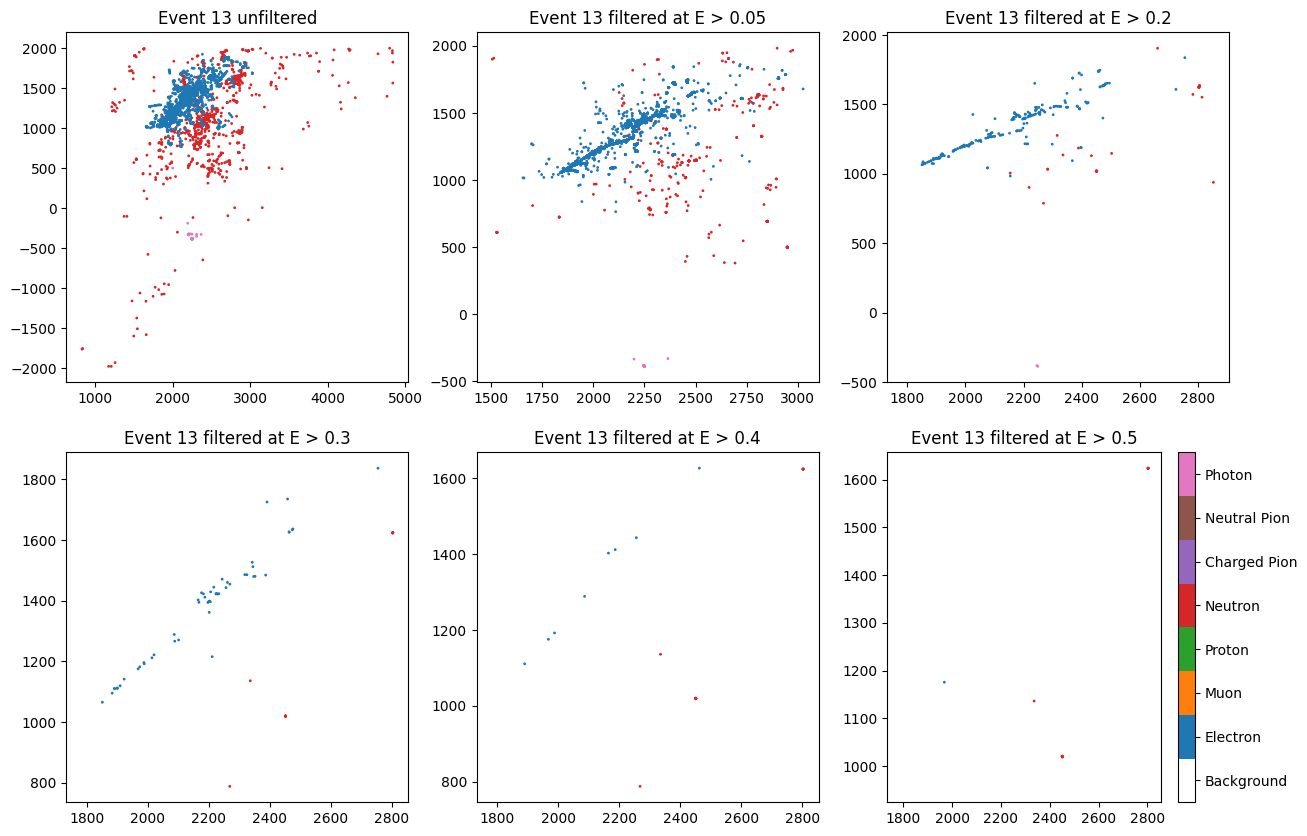

In [51]:
eid = 13
mask = evtid == eid
targets_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("targets", colors=["#FFFFFF", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", '#8c564b', '#e377c2'], N=8)
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15,10))
im = axs.ravel()[0].scatter(coords[mask,2], coords[mask,0], s=1, cmap=targets_cmap, c=classes[mask], vmin=-0.5, vmax=7.5)
axs.ravel()[0].set_title(f"Event {eid} unfiltered")

for ax, bound in zip(axs.ravel()[1:], [0.05, 0.20, 0.30, 0.40, 0.50]):
    mask &= edep > bound
    im = ax.scatter(coords[mask,2], coords[mask,0], s=1, cmap=targets_cmap, c=classes[mask], vmin=-0.5, vmax=7.5)
    ax.set_title(f"Event {eid} filtered at E > {bound}")

cbar = fig.colorbar(im, ticks=[0,1,2,3,4,5,6,7])
cbar.ax.set_yticklabels(["Background", "Electron", "Muon", "Proton", "Neutron", "Charged Pion", "Neutral Pion", "Photon"])
plt.show()

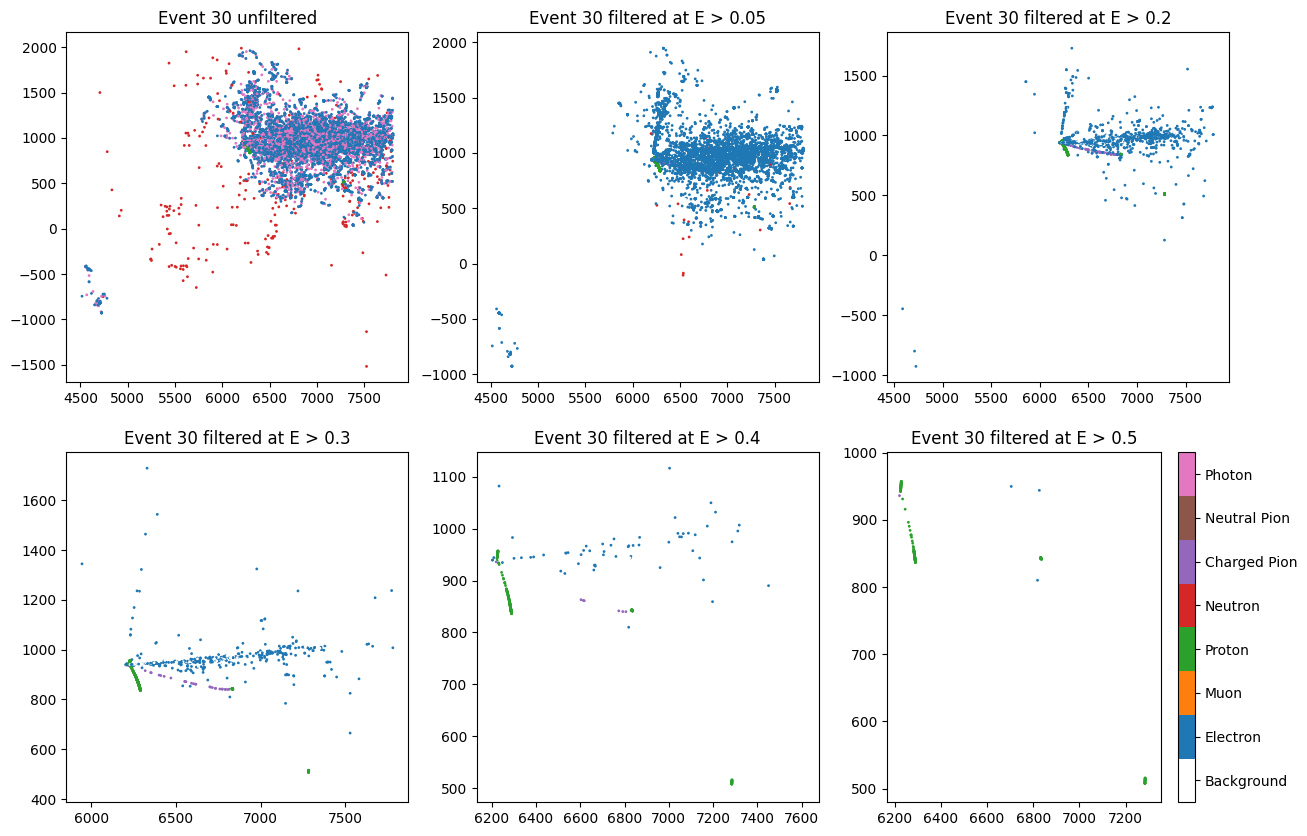

In [54]:
eid = 30
mask = evtid == eid
targets_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("targets", colors=["#FFFFFF", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", '#8c564b', '#e377c2'], N=8)
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15,10))
im = axs.ravel()[0].scatter(coords[mask,2], coords[mask,0], s=1, cmap=targets_cmap, c=trueclasses[mask], vmin=-0.5, vmax=7.5)
axs.ravel()[0].set_title(f"Event {eid} unfiltered")

for ax, bound in zip(axs.ravel()[1:], [0.05, 0.20, 0.30, 0.40, 0.50]):
    mask &= edep > bound
    im = ax.scatter(coords[mask,2], coords[mask,0], s=1, cmap=targets_cmap, c=trueclasses[mask], vmin=-0.5, vmax=7.5)
    ax.set_title(f"Event {eid} filtered at E > {bound}")

cbar = fig.colorbar(im, ticks=[0,1,2,3,4,5,6,7])
cbar.ax.set_yticklabels(["Background", "Electron", "Muon", "Proton", "Neutron", "Charged Pion", "Neutral Pion", "Photon"])
plt.show()

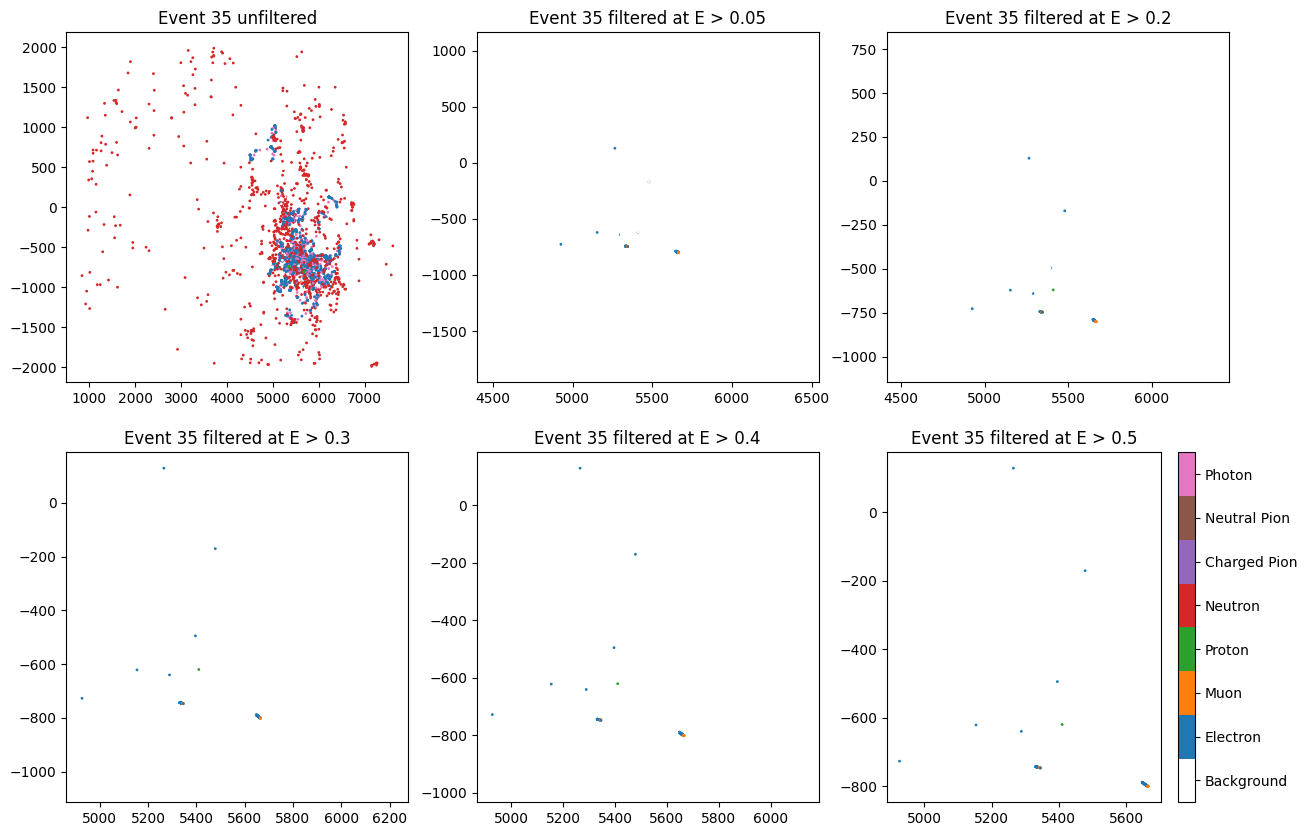

In [55]:
eid = 35
mask = evtid == eid
targets_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("targets", colors=["#FFFFFF", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", '#8c564b', '#e377c2'], N=8)
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15,10))
im = axs.ravel()[0].scatter(coords[mask,2], coords[mask,0], s=1, cmap=targets_cmap, c=trueclasses[mask], vmin=-0.5, vmax=7.5)
axs.ravel()[0].set_title(f"Event {eid} unfiltered")

for ax, bound in zip(axs.ravel()[1:], [0.05, 0.20, 0.30, 0.40, 0.50]):
    mask &= edep > bound
    im = ax.scatter(coords[mask,2], coords[mask,0], s=1, cmap=targets_cmap, c=trueclasses[mask], vmin=-0.5, vmax=7.5)
    ax.set_title(f"Event {eid} filtered at E > {bound}")

cbar = fig.colorbar(im, ticks=[0,1,2,3,4,5,6,7])
cbar.ax.set_yticklabels(["Background", "Electron", "Muon", "Proton", "Neutron", "Charged Pion", "Neutral Pion", "Photon"])
plt.show()

63.138152674771845
63.138152674771845
63.138152674771845
63.138152674771845
63.138152674771845
63.138152674771845


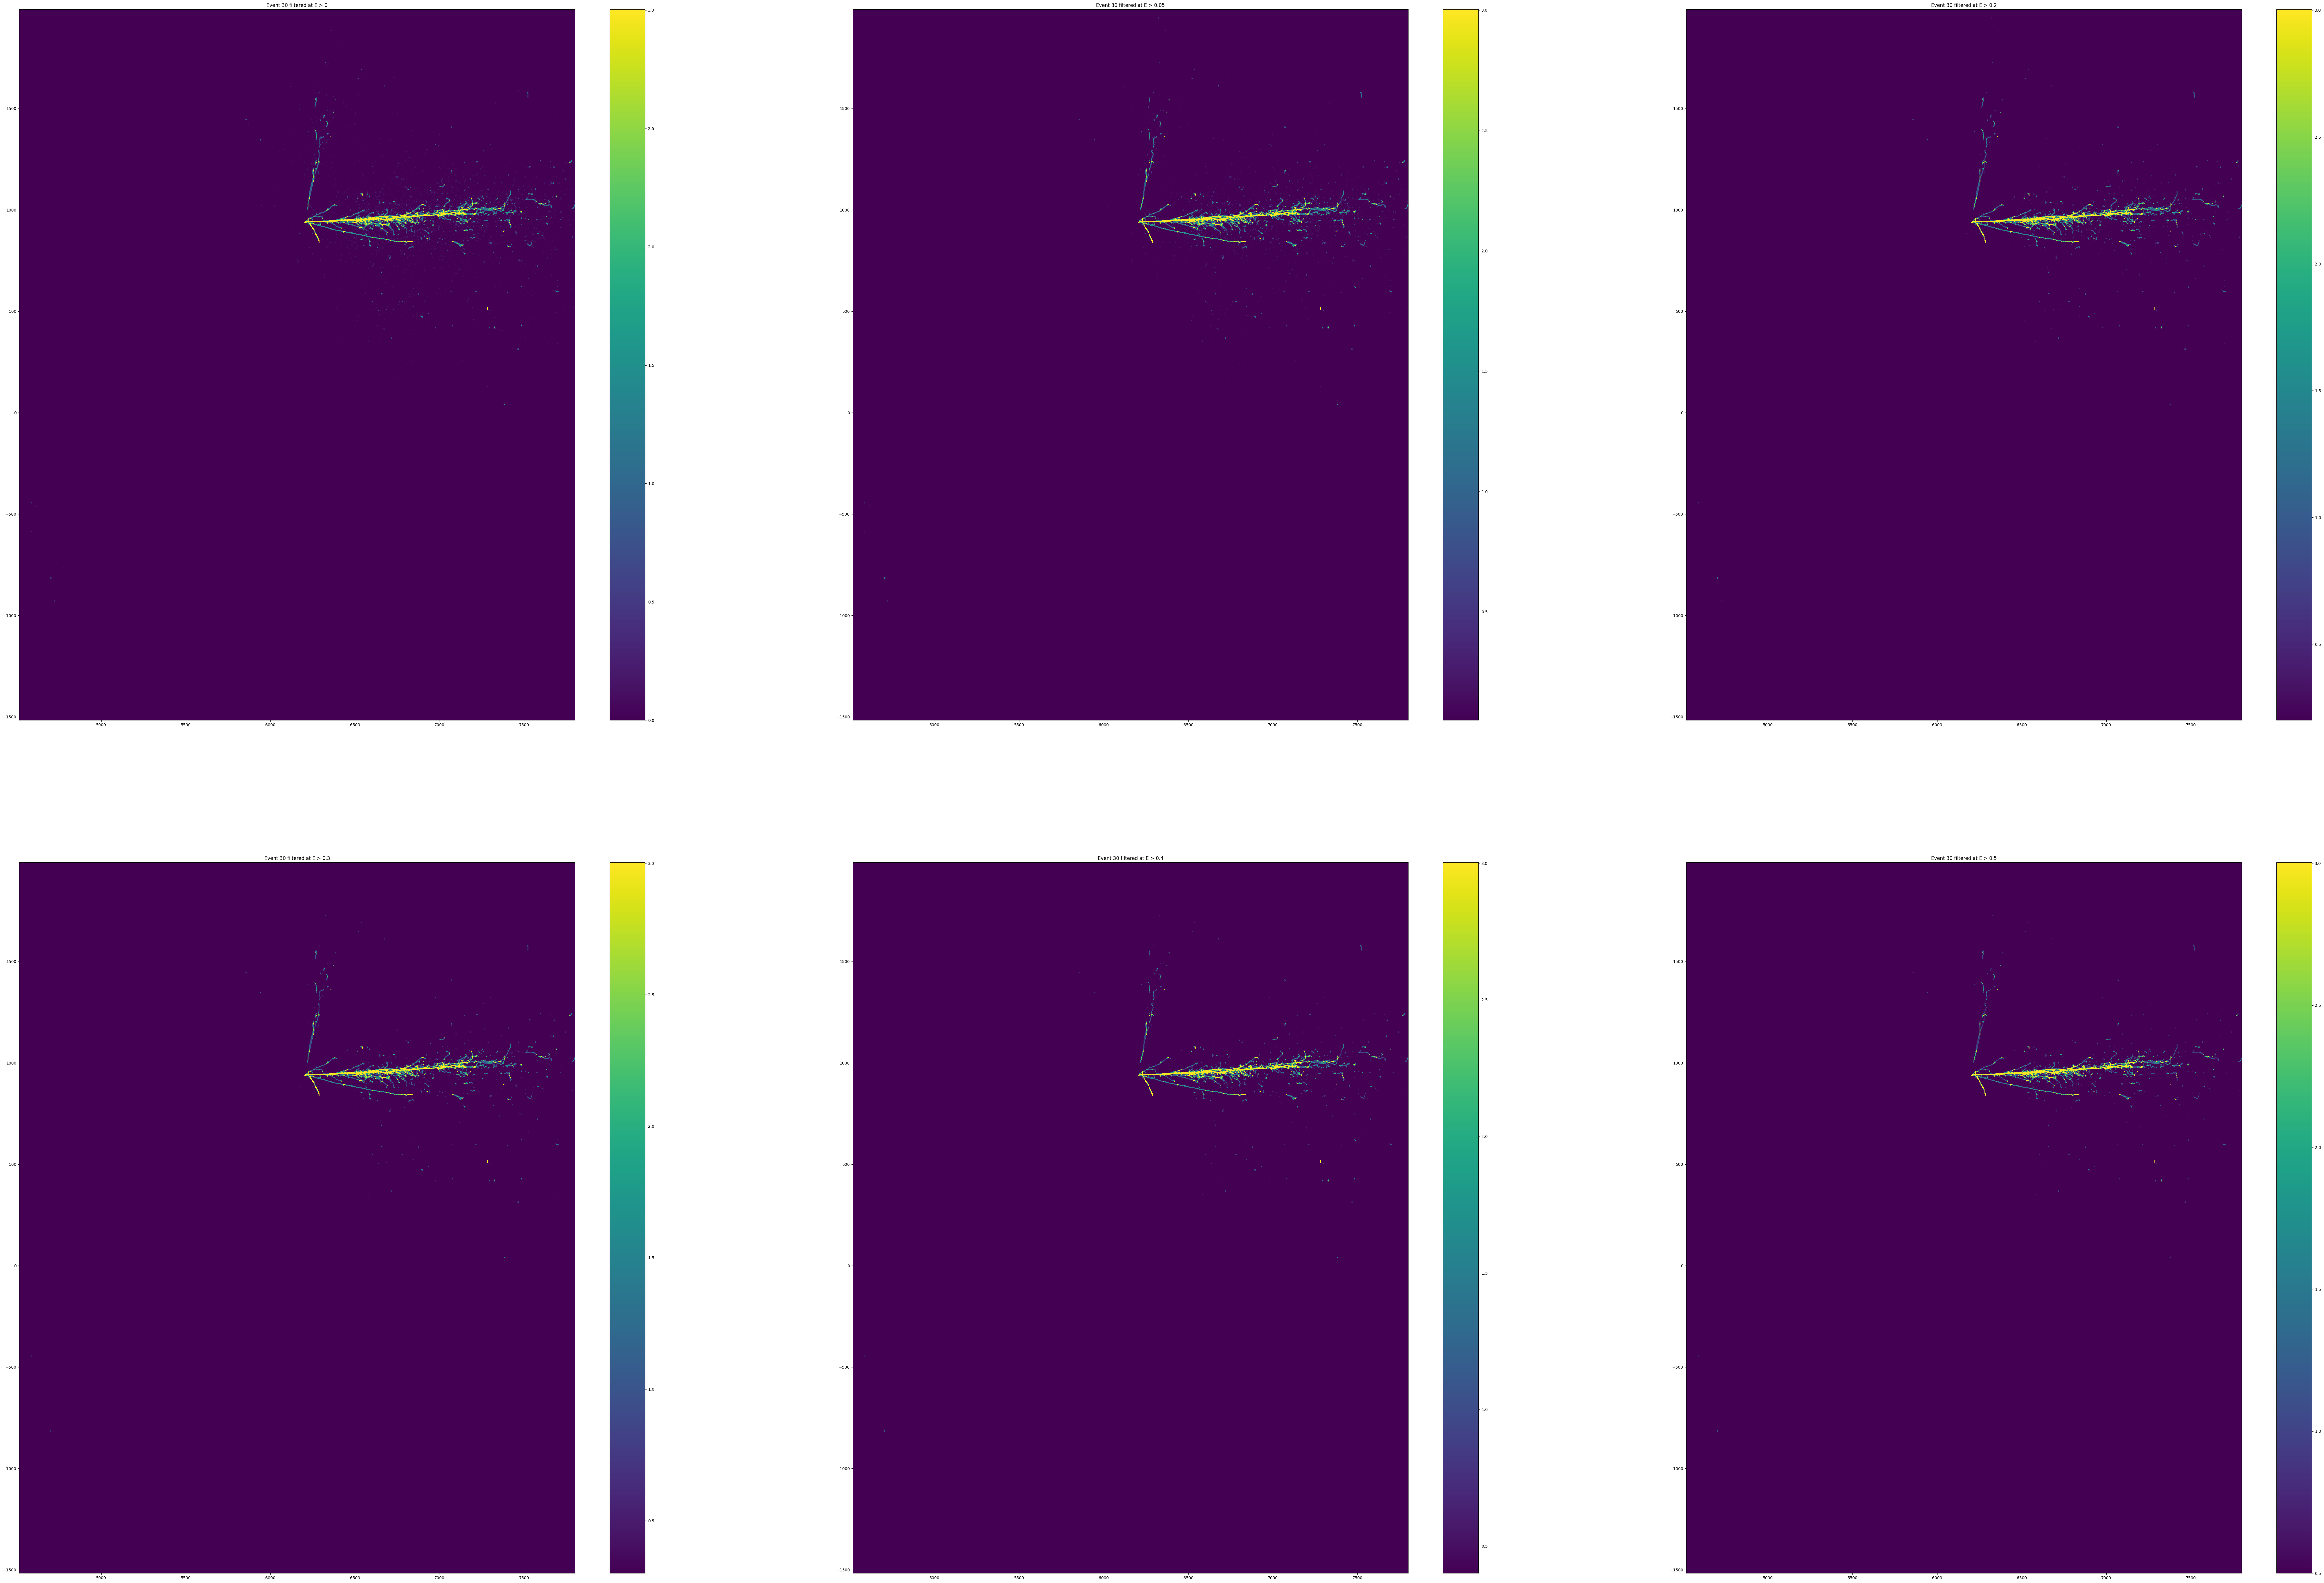

In [121]:
#eid = 13 
eid=30
mask = evtid == eid
targets_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("targets", colors=["#FFFFFF", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", '#8c564b', '#e377c2'], N=8)
scale = 7
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(scale*15,scale*10))

for ax, bound in zip(axs.ravel(), [0, 0.05, 0.20, 0.30, 0.40, 0.5]):
    #mask &= edep > bound
    #im = ax.scatter(coords[mask,2], coords[mask,0], s=1, c=edep[mask])
    coord_range_z = coords[mask, 2].min(), coords[mask, 2].max()
    coord_range_x = coords[mask, 0].min(), coords[mask, 0].max()
    bins_z = (coord_range_z[1] - coord_range_z[0]) // 5
    bins_x = (coord_range_x[1] - coord_range_x[0]) // 5
    
    h, xedges, yedges, im = ax.hist2d(coords[mask, 2], coords[mask, 0], bins=(int(bins_z+1), int(bins_x+1)), weights=edep[mask], vmin=bound)
    im.set_clim(vmin=bound, vmax=np.percentile(h, 99.9))
    print(h.max())

    ax.set_title(f"Event {eid} filtered at E > {bound}")
    cbar = fig.colorbar(im, ax=ax)


#cbar.ax.set_yticklabels(["Background", "Electron", "Muon", "Proton", "Neutron", "Charged Pion", "Neutral Pion", "Photon"])
plt.show()

In [193]:
from scipy.signal import convolve2d, convolve

[656 701]
(9, 657, 702)


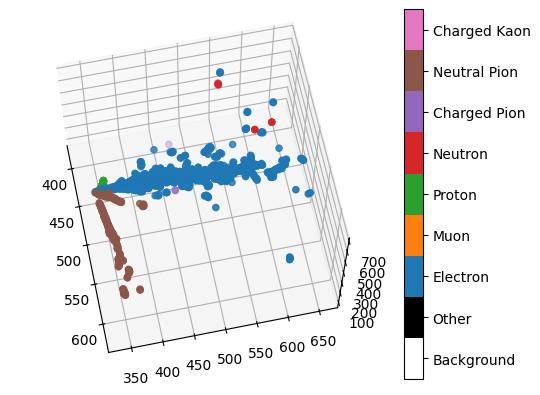

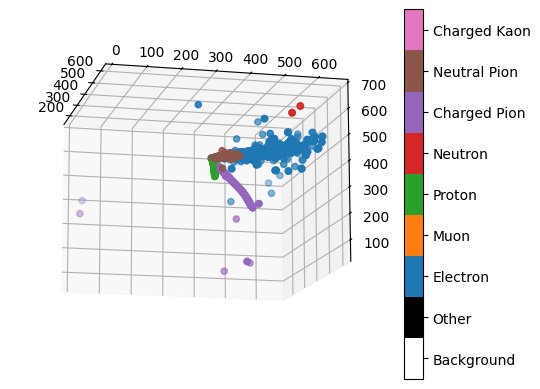

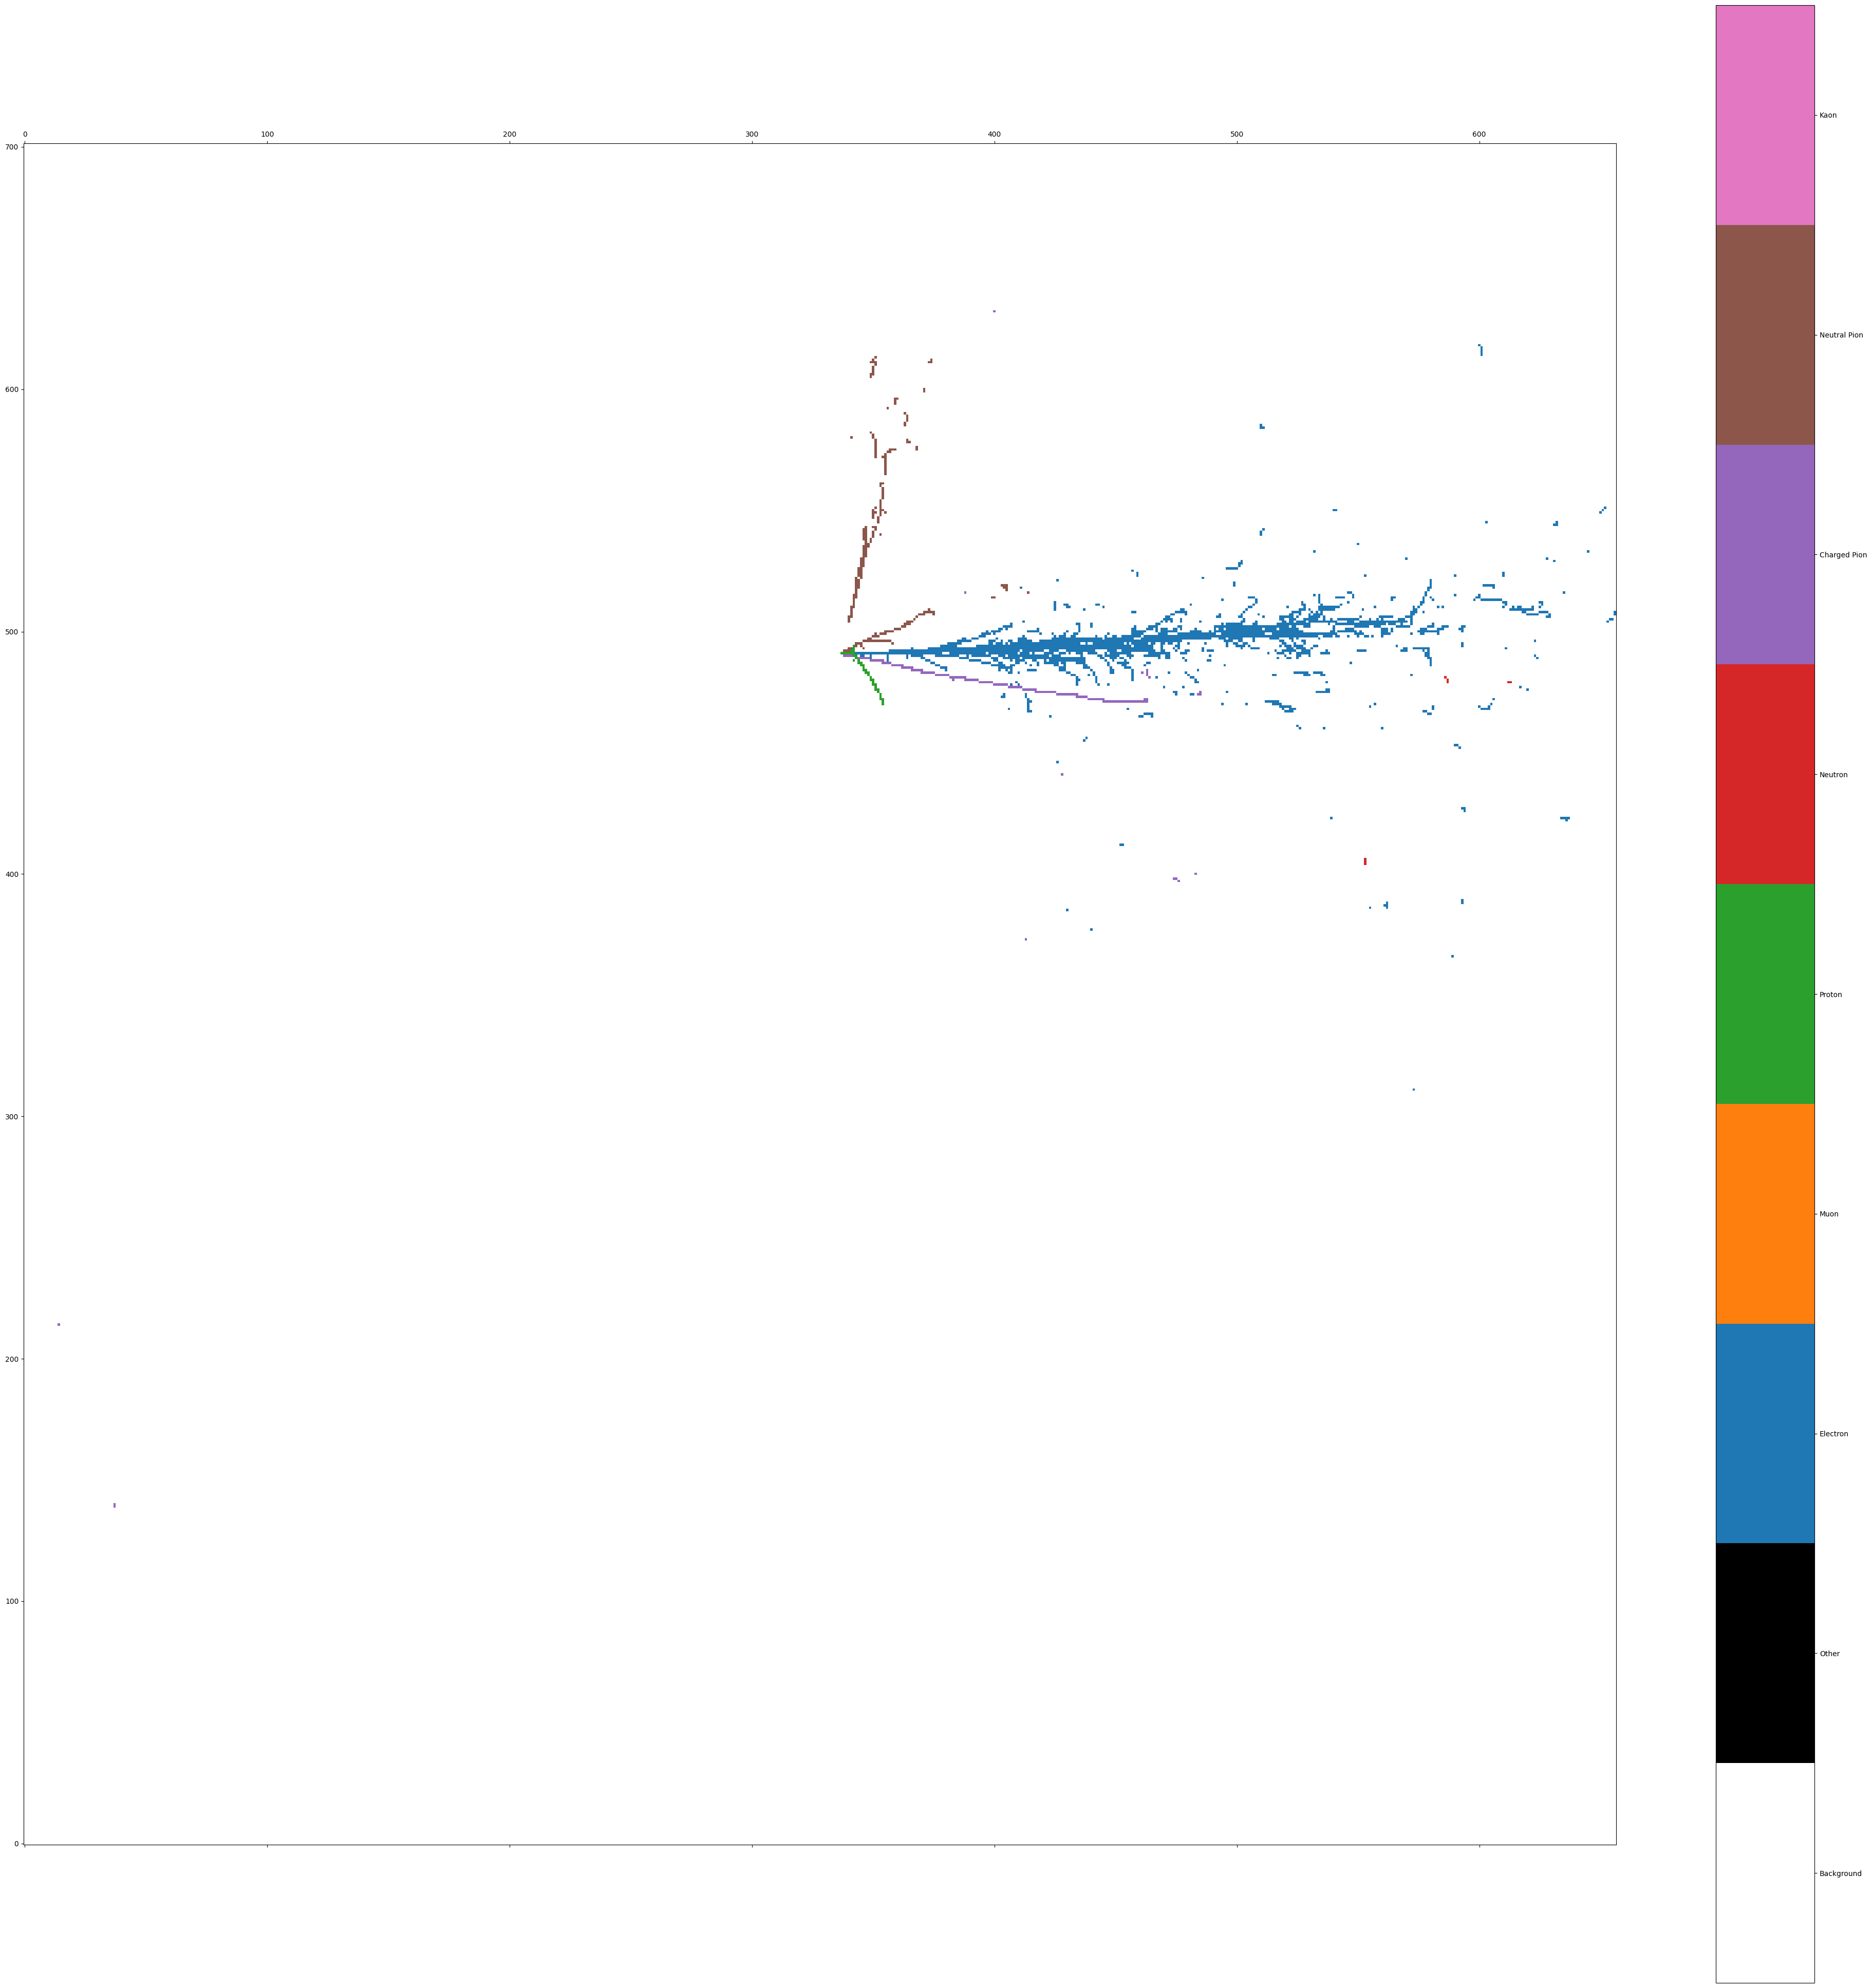

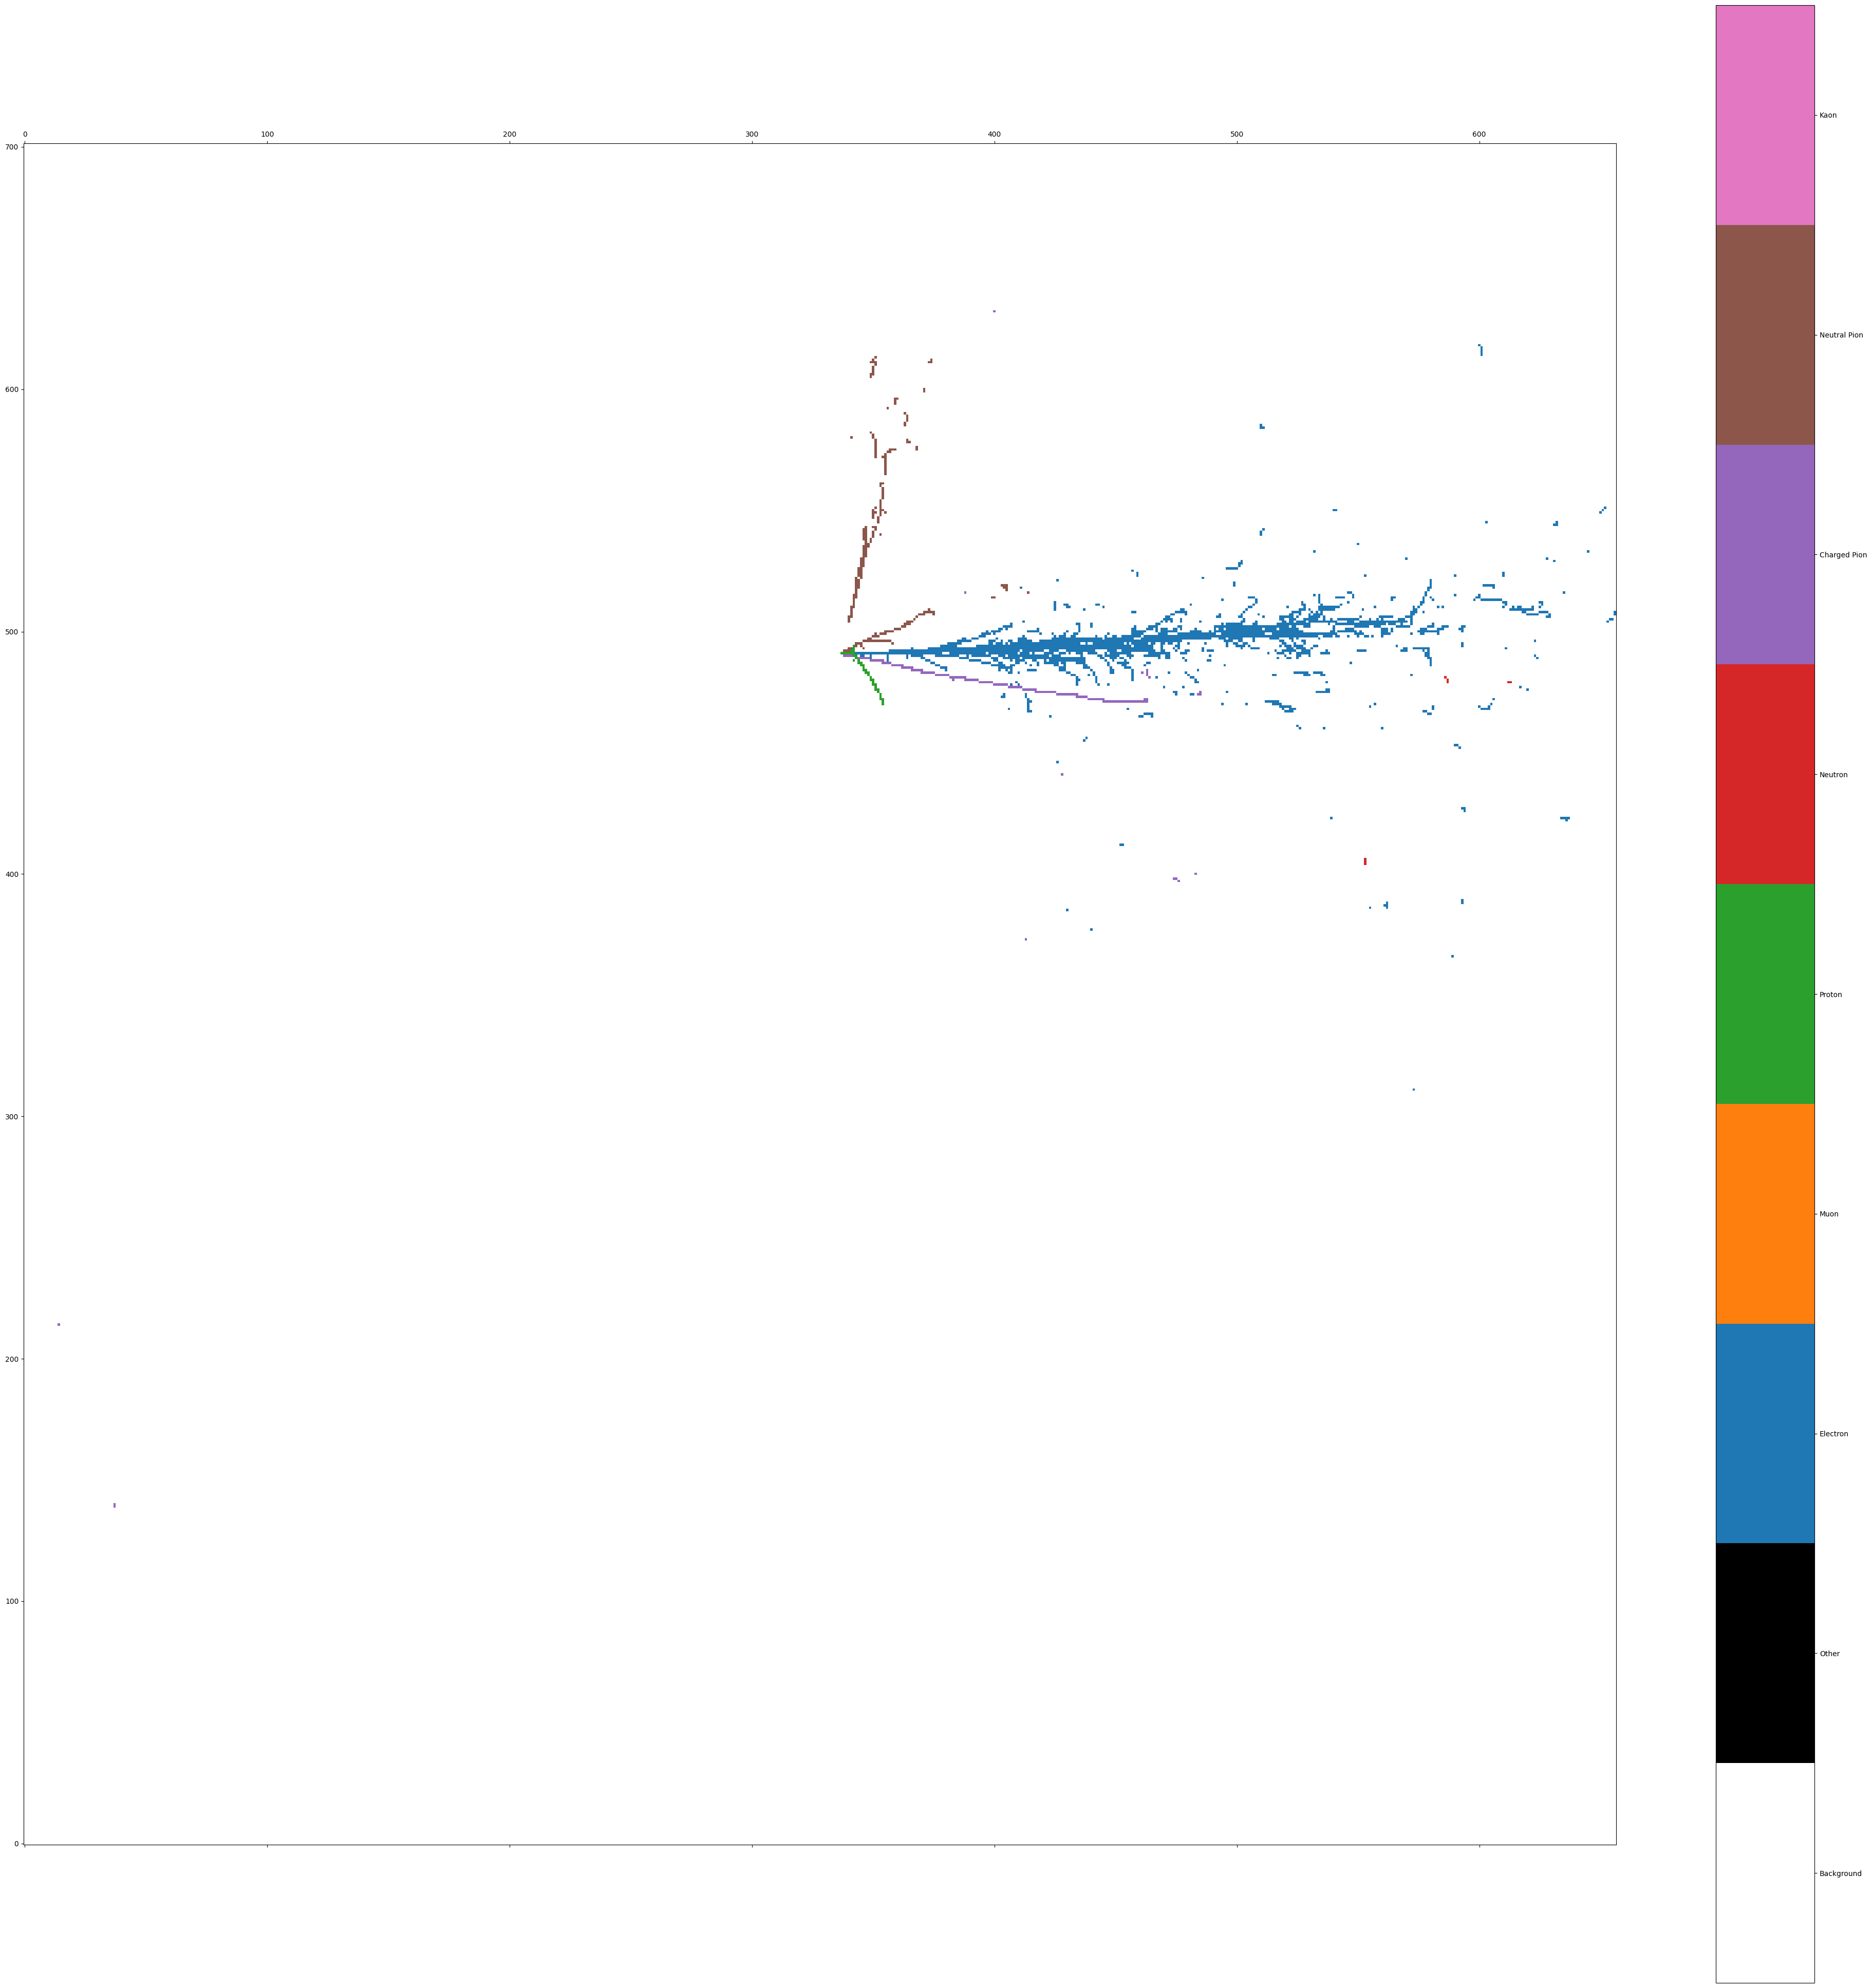

In [202]:
eid = 30
#eid=13
mask = evtid == eid
#mask &= edep > 0.05
targets_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("targets", colors=["#FFFFFF", "#000000", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", '#8c564b', '#e377c2'], N=9)
scale = 10
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(scale*5,scale*5))
coord_range_z = coords[mask, 2].min(), coords[mask, 2].max()
coord_range_x = coords[mask, 0].min(), coords[mask, 0].max()
bins_z = (coord_range_z[1] - coord_range_z[0]) // 5
bins_x = (coord_range_x[1] - coord_range_x[0]) // 5
#mat = np.zeros((int(bins_z)+1, int(bins_x)+1))
energy_agg = np.zeros((9, int(bins_z)+1, int(bins_x)+1))
pixel_coords = ((coords[mask] - coords[mask].min(axis=0, keepdims=True)) // 5).astype(int)



print(pixel_coords[:, [2,0]].max(axis=0))
print(energy_agg.shape)
np.add.at(energy_agg, (classes[mask]+1, pixel_coords[:,2], pixel_coords[:,0]), edep[mask])

#draw_order = np.argsort(edep[mask])
#mat[pixel_coords[draw_order, 2], pixel_coords[draw_order, 0]] = trueclasses[mask][draw_order]+1

agged_energy = convolve2d(energy_agg.sum(axis=0), [[1,1,1],[1,0,1],[1,1,1]], mode='same')

mat = np.argmax(energy_agg, axis=0)
mat[energy_agg.sum(axis=0) < 0.5] = 0
mat[agged_energy < 0.05] = 0
im = axs.matshow(mat.T, cmap=targets_cmap, vmin=-0.5, vmax=8.5)
axs.invert_yaxis()

cbar = fig.colorbar(im, ticks=[0,1,2,3,4,5,6,7, 8])
cbar.ax.set_yticklabels(["Background", "Other", "Electron", "Muon", "Proton", "Neutron", "Charged Pion", "Neutral Pion", "Kaon"])
plt.show()

Text(0, 0.5, 'count')

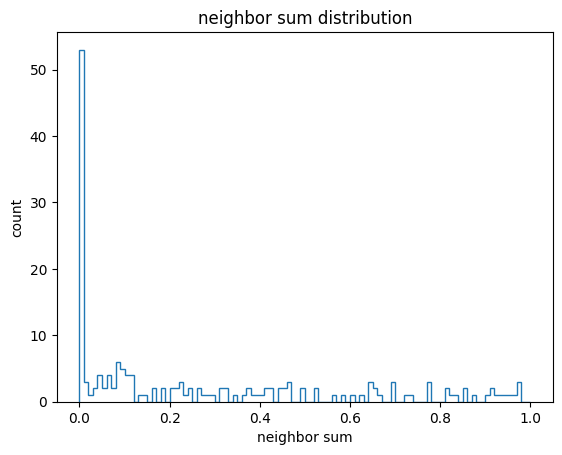

In [191]:
plt.hist(agged_energy[mat != 0], bins=100, histtype="step", range=(0,1))
plt.title("neighbor sum distribution")
plt.xlabel("neighbor sum")
plt.ylabel("count")

[656 701]
(9, 657, 702)


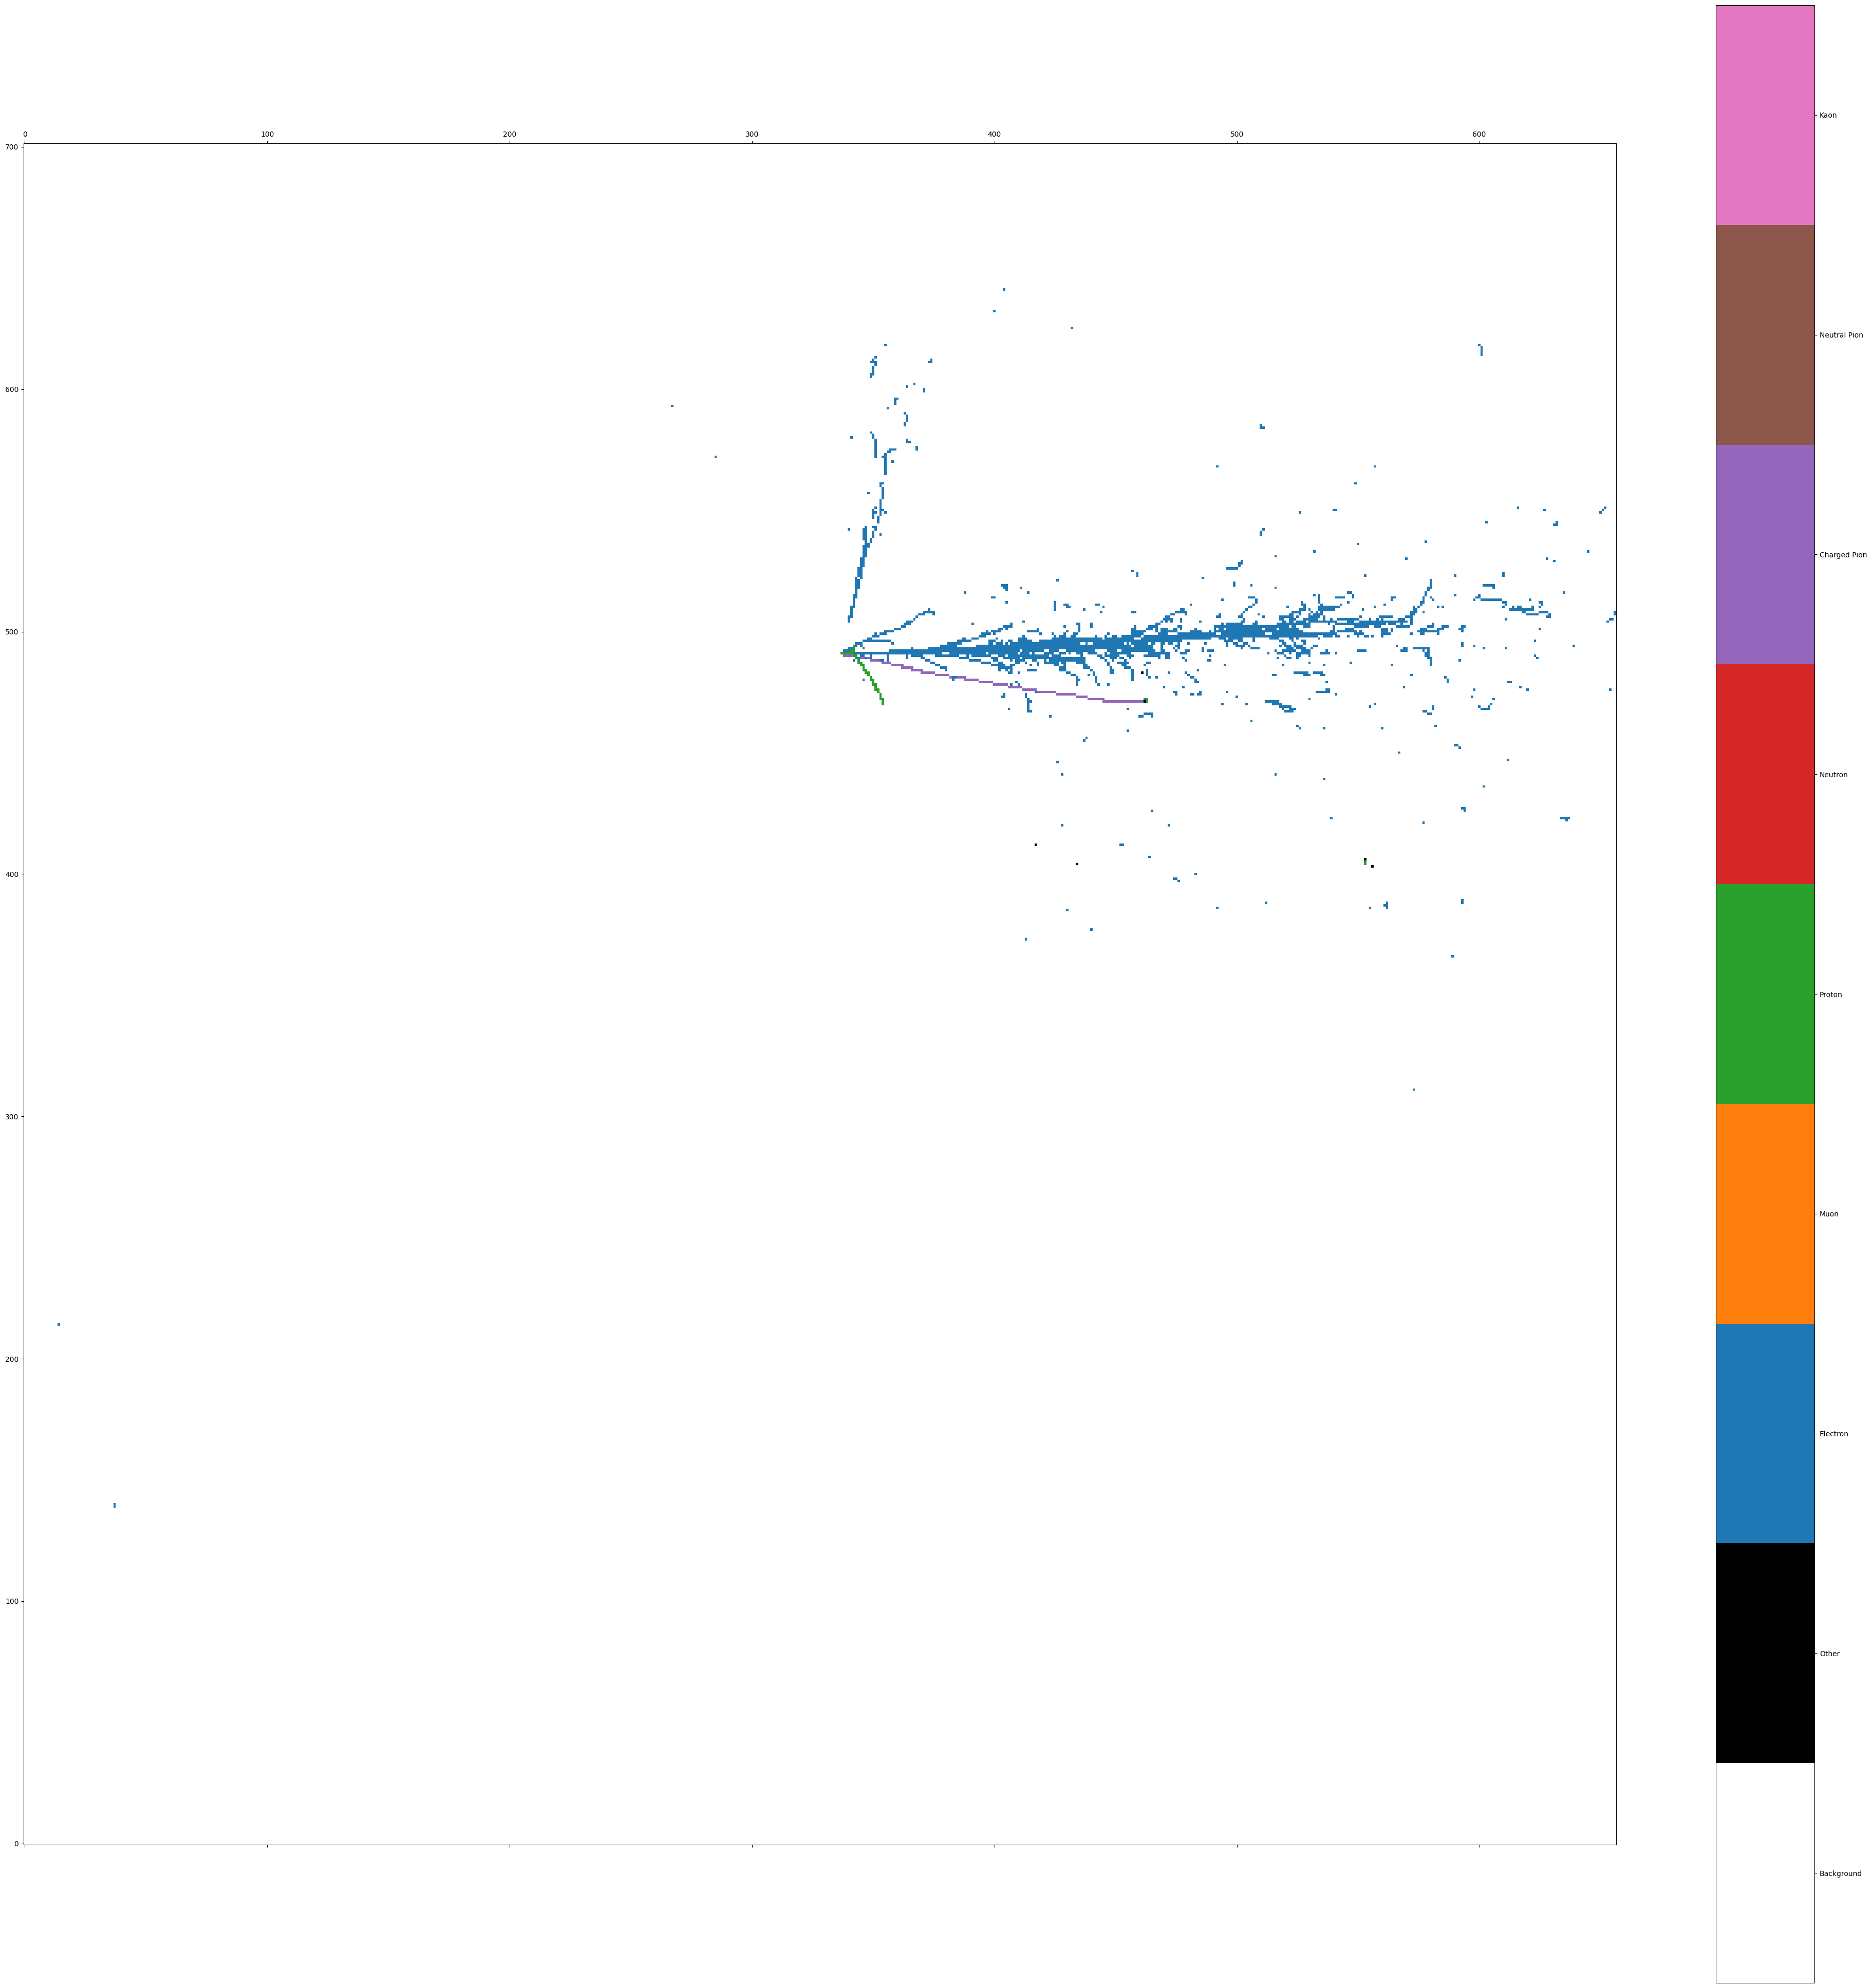

In [159]:
eid = 30
#eid=13
mask = evtid == eid
#mask &= edep > 0.05
targets_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("targets", colors=["#FFFFFF", "#000000", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", '#8c564b', '#e377c2'], N=9)
scale = 10
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(scale*5,scale*5))
coord_range_z = coords[mask, 2].min(), coords[mask, 2].max()
coord_range_x = coords[mask, 0].min(), coords[mask, 0].max()
bins_z = (coord_range_z[1] - coord_range_z[0]) // 5
bins_x = (coord_range_x[1] - coord_range_x[0]) // 5
#mat = np.zeros((int(bins_z)+1, int(bins_x)+1))
energy_agg = np.zeros((9, int(bins_z)+1, int(bins_x)+1))
pixel_coords = ((coords[mask] - coords[mask].min(axis=0, keepdims=True)) // 5).astype(int)

print(pixel_coords[:, [2,0]].max(axis=0))
print(energy_agg.shape)
np.add.at(energy_agg, (trueclasses[mask]+1, pixel_coords[:,2], pixel_coords[:,0]), edep[mask])

#draw_order = np.argsort(edep[mask])
#mat[pixel_coords[draw_order, 2], pixel_coords[draw_order, 0]] = trueclasses[mask][draw_order]+1

mat = np.argmax(energy_agg, axis=0)
mat[energy_agg.max(axis=0) < 0.5] = 0
im = axs.matshow(mat.T, cmap=targets_cmap, vmin=-0.5, vmax=8.5)
axs.invert_yaxis()

cbar = fig.colorbar(im, ticks=[0,1,2,3,4,5,6,7, 8])
cbar.ax.set_yticklabels(["Background", "Other", "Electron", "Muon", "Proton", "Neutron", "Charged Pion", "Neutral Pion", "Kaon"])
plt.show()

[656 701]
(9, 657, 702)


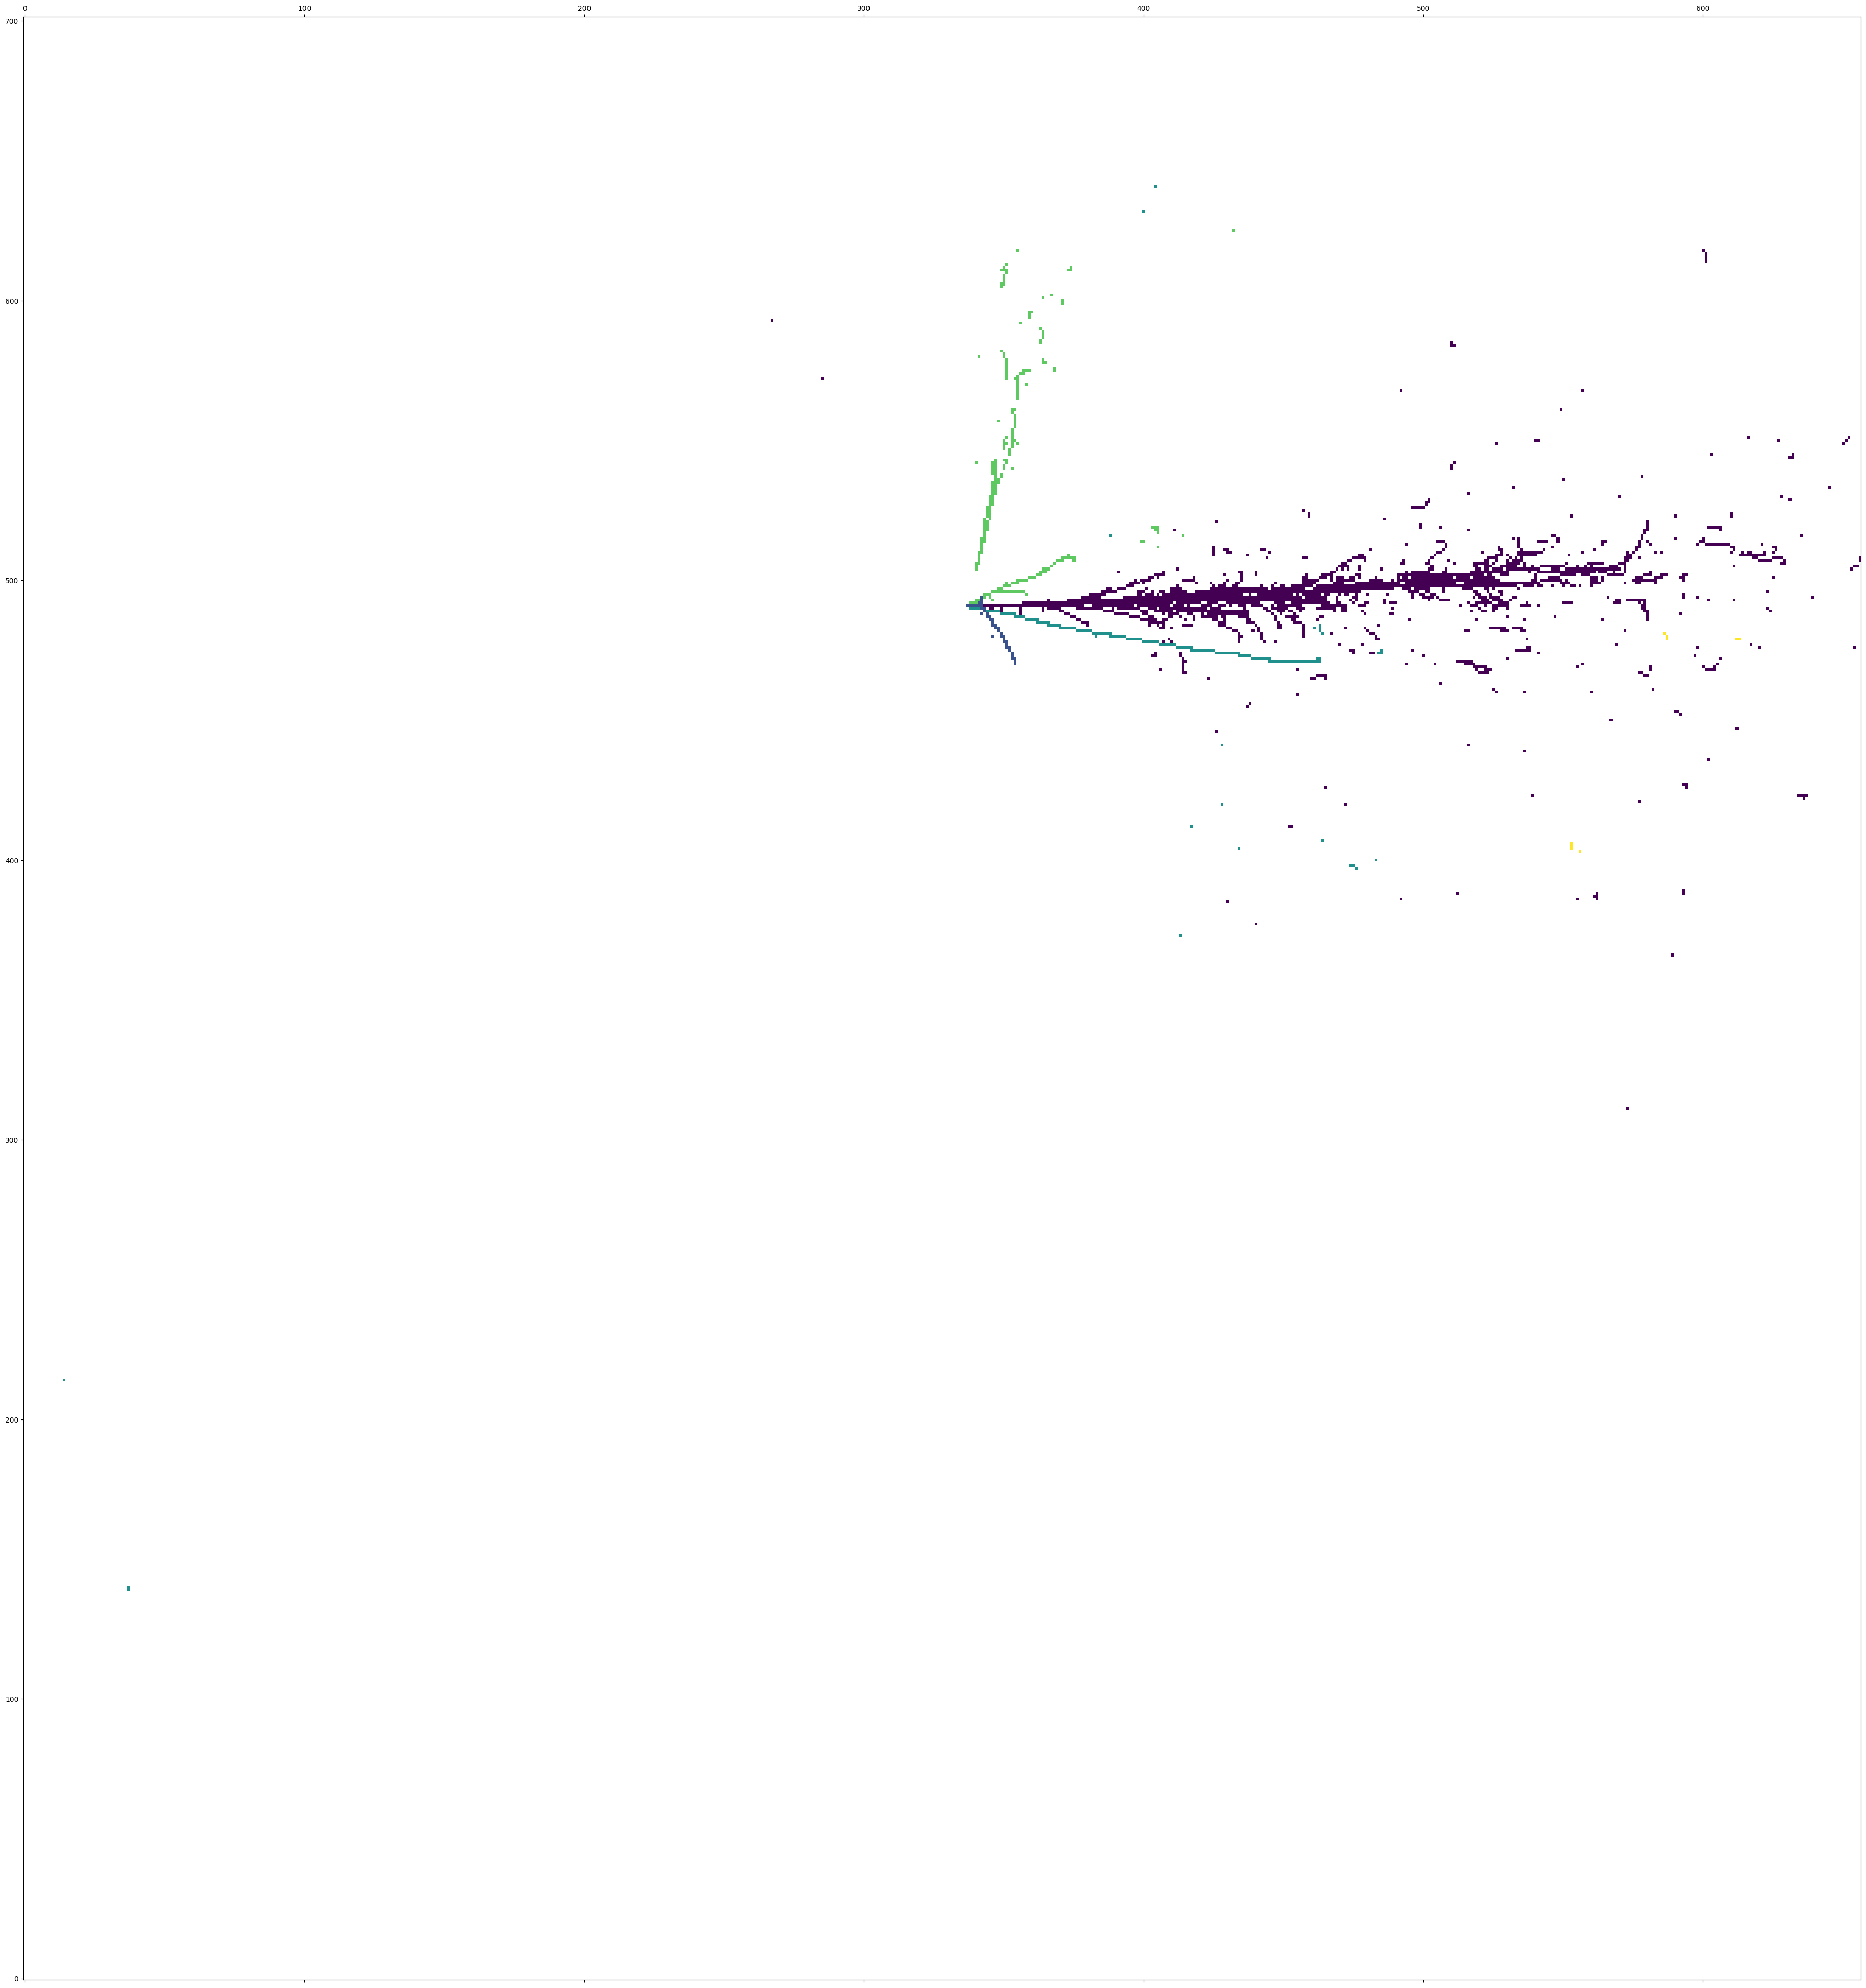

In [127]:
eid = 30
#eid=13
mask = evtid == eid
#mask &= edep > 0.05
#targets_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("targets", colors=["#FFFFFF", "#000000", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", '#8c564b', '#e377c2'], N=9)
scale = 10
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(scale*5,scale*5))
coord_range_z = coords[mask, 2].min(), coords[mask, 2].max()
coord_range_x = coords[mask, 0].min(), coords[mask, 0].max()
bins_z = (coord_range_z[1] - coord_range_z[0]) // 5
bins_x = (coord_range_x[1] - coord_range_x[0]) // 5
#mat = np.zeros((int(bins_z)+1, int(bins_x)+1))
energy_agg = np.zeros((9, int(bins_z)+1, int(bins_x)+1))
pixel_coords = ((coords[mask] - coords[mask].min(axis=0, keepdims=True)) // 5).astype(int)

print(pixel_coords[:, [2,0]].max(axis=0))
print(energy_agg.shape)
np.add.at(energy_agg, (prongs[mask]+1, pixel_coords[:,2], pixel_coords[:,0]), edep[mask])

#draw_order = np.argsort(edep[mask])
#mat[pixel_coords[draw_order, 2], pixel_coords[draw_order, 0]] = trueclasses[mask][draw_order]+1

mat = np.argmax(energy_agg, axis=0)
mat[energy_agg.max(axis=0) < 0.5] = 0
mat = mat.astype(float)
mat[mat == 0] = np.nan
im = axs.matshow(mat.T)
axs.invert_yaxis()

#cbar = fig.colorbar(im, ticks=[0,1,2,3,4,5,6,7, 8])
#cbar.ax.set_yticklabels(["Background", "Other", "Electron", "Muon", "Proton", "Neutron", "Charged Pion", "Neutral Pion", "Kaon"])
plt.show()

In [197]:
%matplotlib ipympl

[12]


[Text(1, 0, 'Background'),
 Text(1, 1, 'Other'),
 Text(1, 2, 'Electron'),
 Text(1, 3, 'Muon'),
 Text(1, 4, 'Proton'),
 Text(1, 5, 'Neutron'),
 Text(1, 6, 'Charged Pion'),
 Text(1, 7, 'Neutral Pion'),
 Text(1, 8, 'Charged Kaon')]

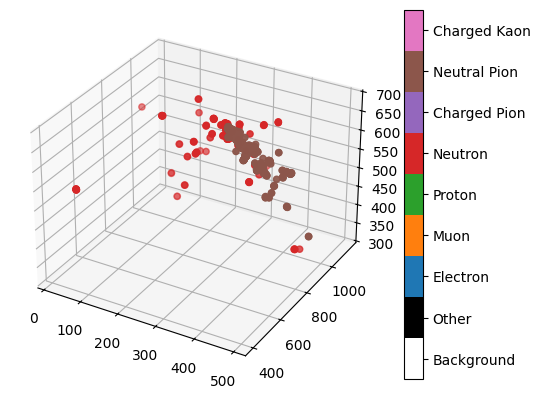

In [280]:
eid = 33
mask = evtid == eid
print(np.unique(pdgs[mask][classes[mask] == 0]))
#mask &= edep > 0.05
targets_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("targets", colors=["#FFFFFF", "#000000", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", '#8c564b', '#e377c2'], N=9)
scale = 10
#fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(scale*5,scale*5))
#coord_range_z = coords[mask, 2].min(), coords[mask, 2].max()
#coord_range_x = coords[mask, 0].min(), coords[mask, 0].max()
#bins_z = (coord_range_z[1] - coord_range_z[0]) // 5
#bins_x = (coord_range_x[1] - coord_range_x[0]) // 5
#mat = np.zeros((int(bins_z)+1, int(bins_x)+1))
coord_range = coords[mask].min(axis=0), coords[mask].max(axis=0)
bins = ((coord_range[1] - coord_range[0]) // 5 + 1).astype(int)

energy_agg = np.zeros((9, *bins))
pixel_coords = ((coords[mask] - coords[mask].min(axis=0, keepdims=True)) // 5).astype(int)

np.add.at(energy_agg, (classes[mask]+1, pixel_coords[:,0], pixel_coords[:,1], pixel_coords[:,2]), edep[mask])

neighbor_energy = energy_agg.sum(axis=0)
neighbor_energy[neighbor_energy < 0.05] = 0
agged_energy = convolve(neighbor_energy, [[[1,1,1],[1,1,1],[1,1,1]],[[1,1,1],[1,0,1],[1,1,1]],[[1,1,1],[1,1,1],[1,1,1]]], mode='same')

mat = np.argmax(energy_agg, axis=0)
mat[energy_agg.sum(axis=0) < 0.05] = 0
mat[agged_energy < 0.2] = 0
coordx,coordy,coordz = np.nonzero(mat)
aggclass = mat[coordx,coordy,coordz]
aggenergy = energy_agg.max(axis=0)[coordx,coordy,coordz]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
im = ax.scatter(coordx, coordz, coordy, c=aggclass, cmap=targets_cmap, vmin=-0.5, vmax=8.5)

#im = axs.matshow(mat.T, cmap=targets_cmap, vmin=-0.5, vmax=8.5)
#axs.invert_yaxis()

cbar = fig.colorbar(im, ticks=[0,1,2,3,4,5,6,7, 8])
cbar.ax.set_yticklabels(["Background", "Other", "Electron", "Muon", "Proton", "Neutron", "Charged Pion", "Neutral Pion", "Charged Kaon"])

In [281]:
agged_energy.shape

(797, 798, 1343)

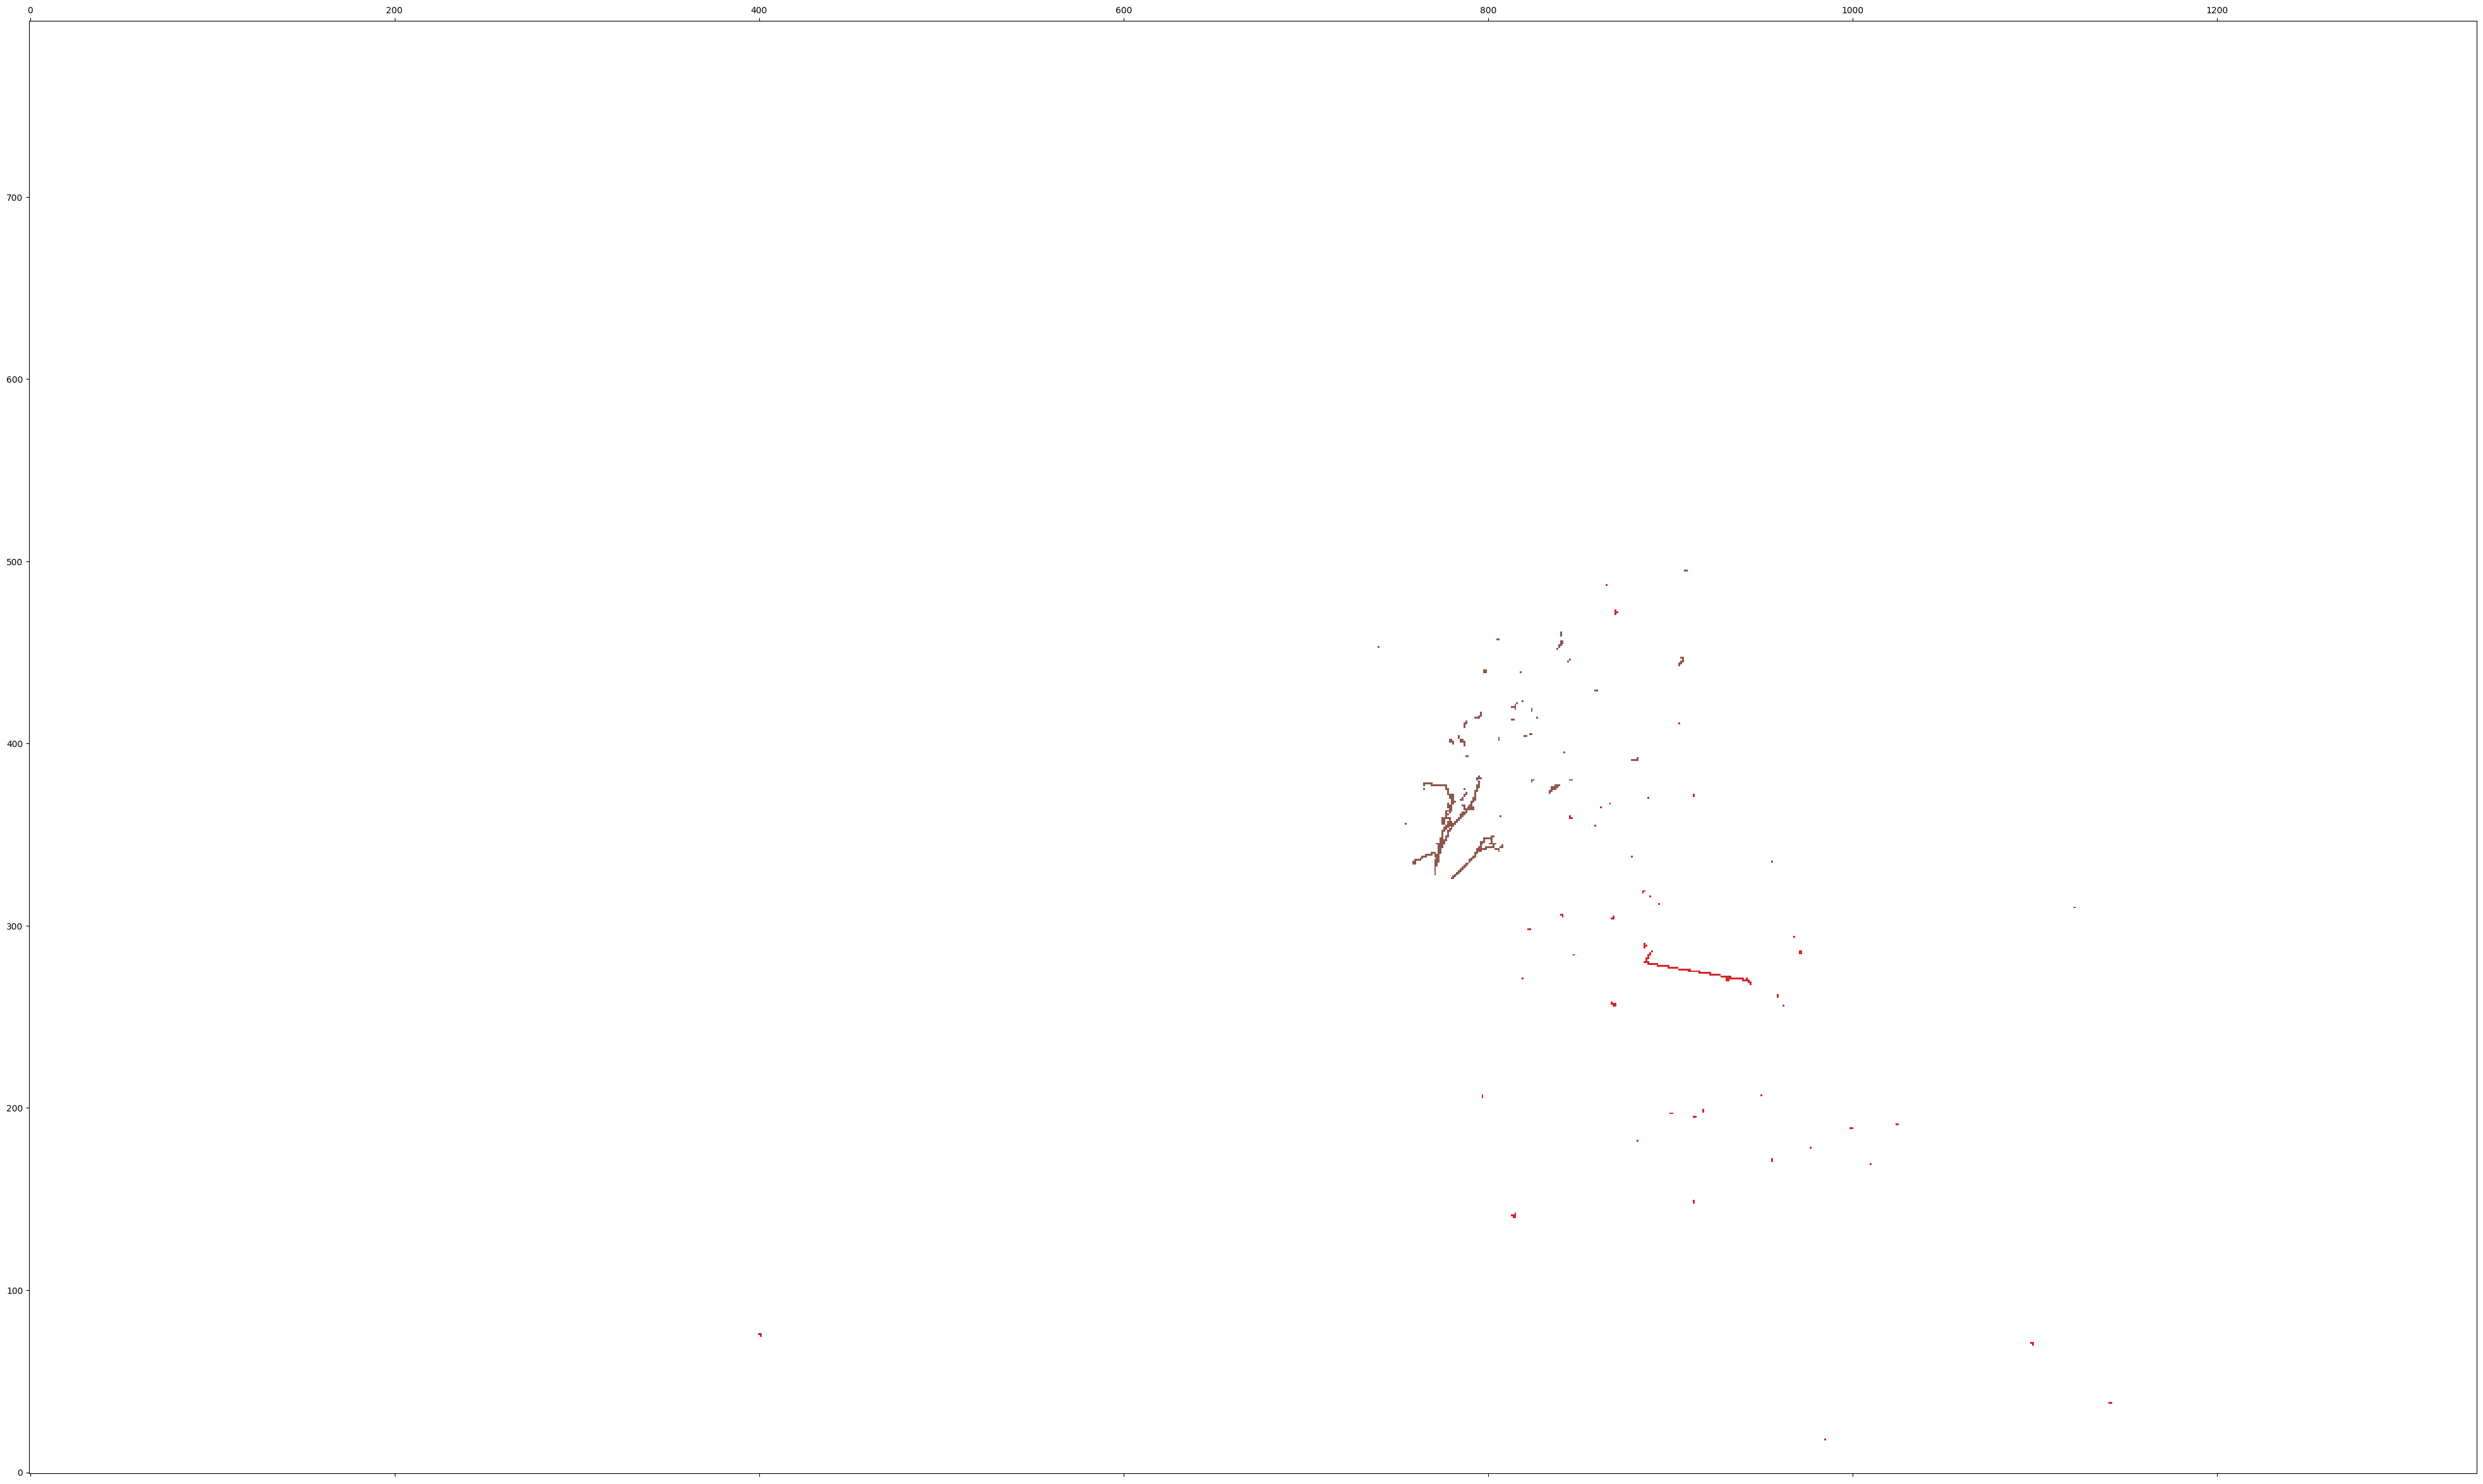

In [282]:
mat2d = np.zeros((agged_energy.shape[2], agged_energy.shape[0]))

mat2d[coordz, coordx] = aggclass

scale = 10
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(scale*5,scale*5))
mat2d[mat2d == 0] = np.nan
im = axs.matshow(mat2d.T, cmap=targets_cmap, vmin=-0.5, vmax=8.5)
axs.invert_yaxis()
plt.show()

In [201]:
%matplotlib inline

Text(0, 0.5, 'Count')

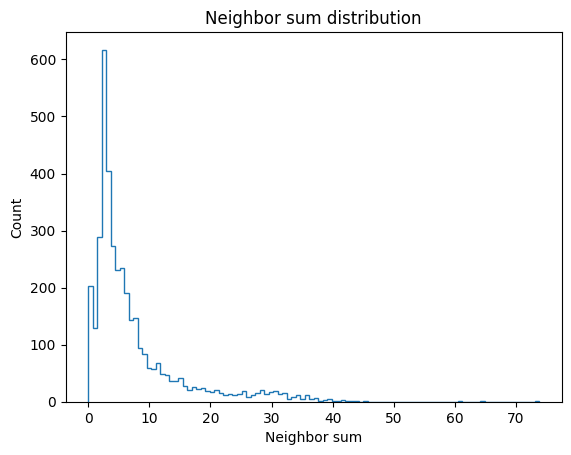

In [196]:
plt.hist(agged_energy[mat != 0], bins=100, histtype="step")
plt.title("Neighbor sum distribution")
plt.xlabel("Neighbor sum")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

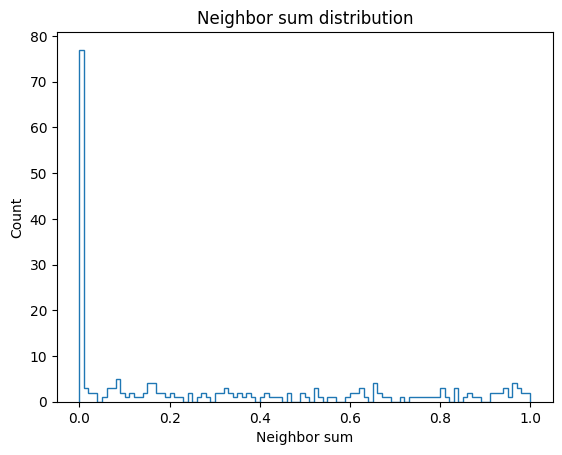

In [195]:
plt.hist(agged_energy[mat != 0], bins=100, histtype="step", range=(0,1))
plt.title("Neighbor sum distribution")
plt.xlabel("Neighbor sum")
plt.ylabel("Count")

In [142]:
energy_agg.shape

(9, 800, 793, 1398)

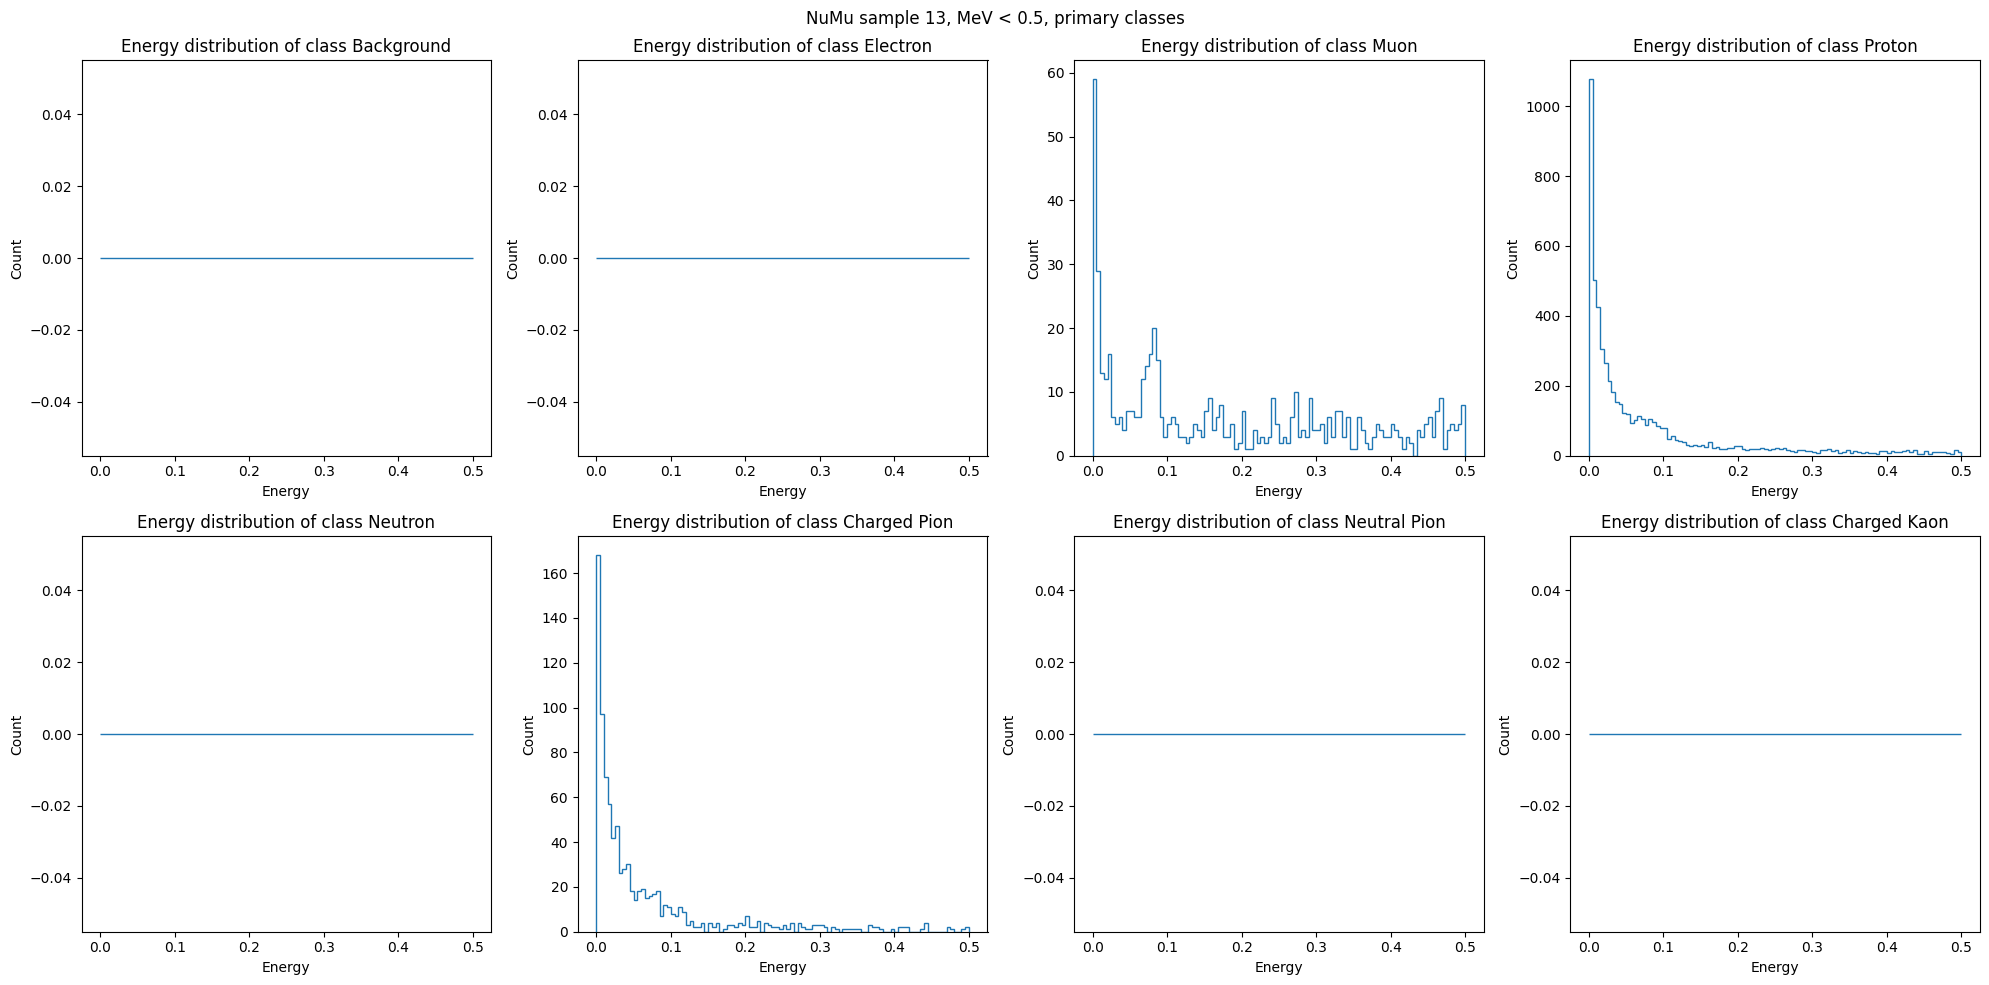

In [147]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20,10))
class_names = ["Background", "Electron", "Muon", "Proton", "Neutron", "Charged Pion", "Neutral Pion", "Charged Kaon"]
for c, ax in enumerate(axs.ravel()):
    mask = (aggclass == c+1) & (aggenergy < 0.5)
    ax.hist(aggenergy[mask], bins=100, histtype='step', range=(0,0.5))
    ax.set_xlabel("Energy")
    ax.set_ylabel("Count")
    ax.set_title(f"Energy distribution of class {class_names[c]}")
plt.suptitle("NuMu sample 13, MeV < 0.5, primary classes")
plt.tight_layout()
plt.show()


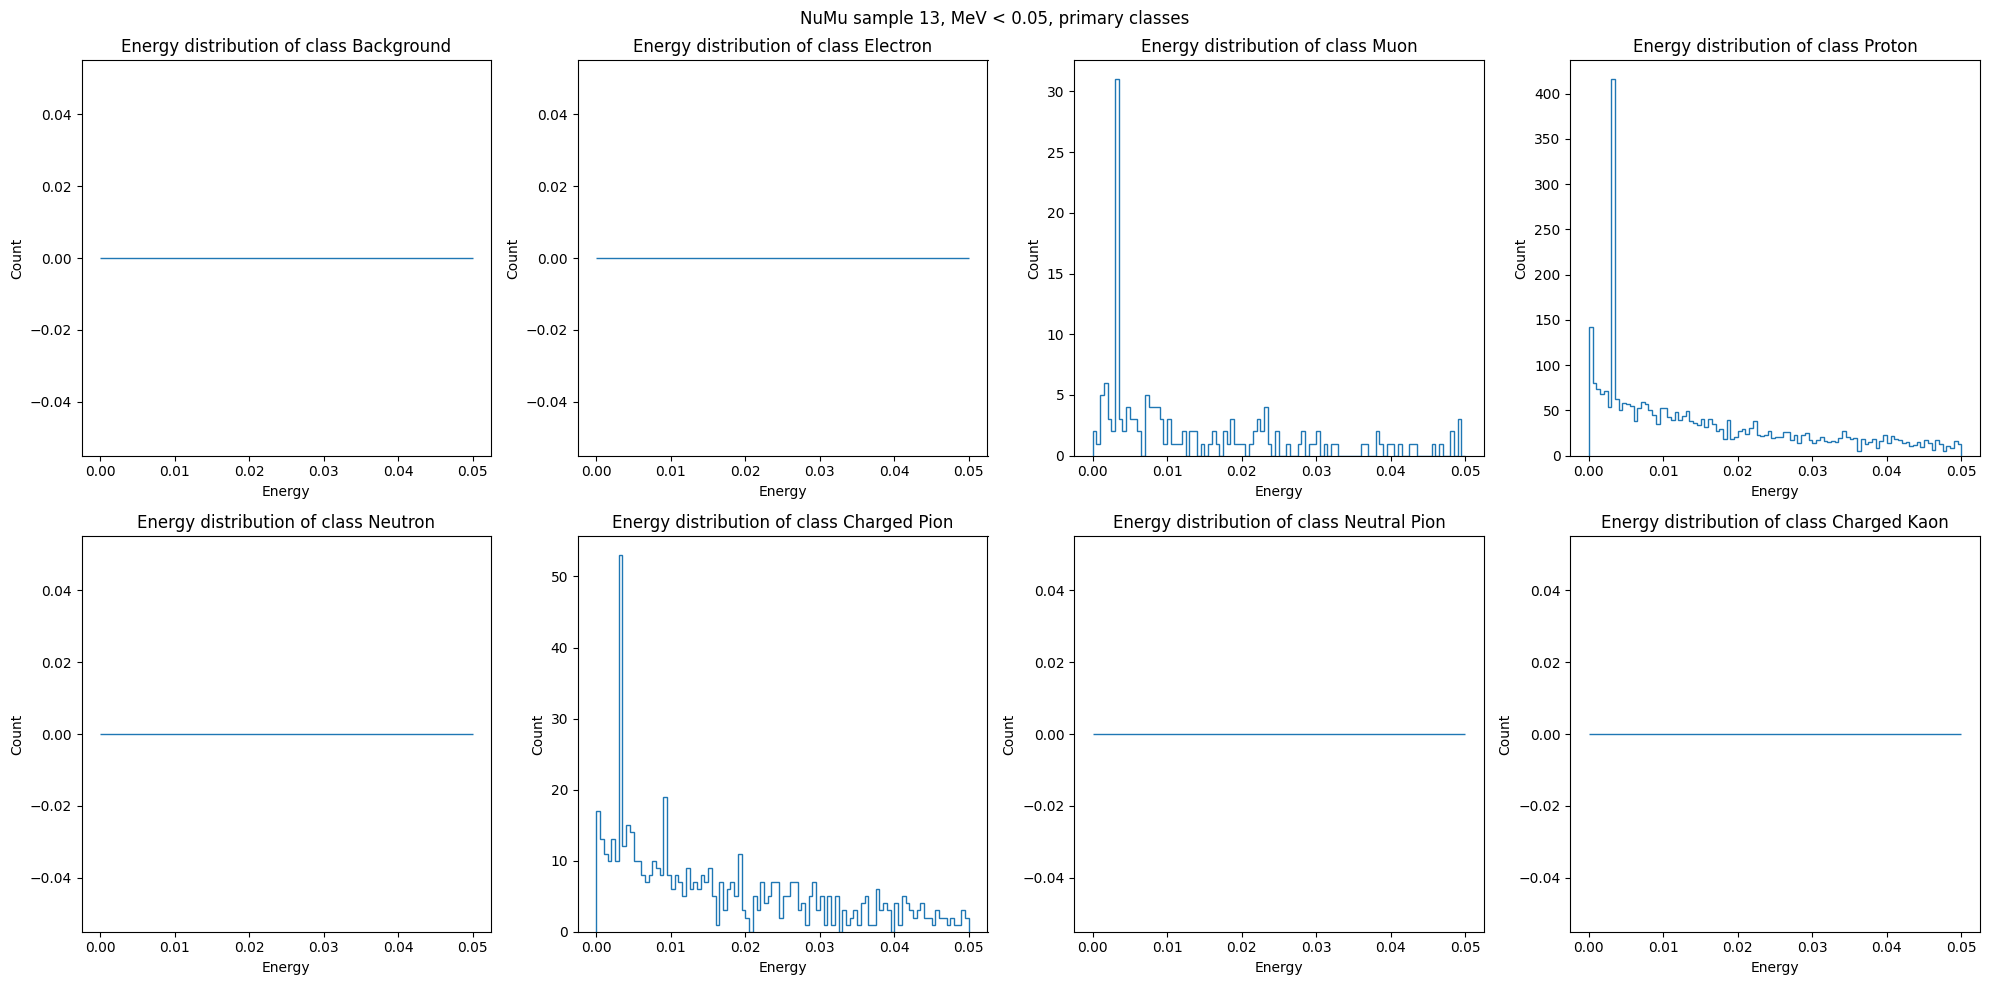

In [148]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20,10))
class_names = ["Background", "Electron", "Muon", "Proton", "Neutron", "Charged Pion", "Neutral Pion", "Charged Kaon"]
for c, ax in enumerate(axs.ravel()):
    mask = (aggclass == c+1) & (aggenergy < 0.05)
    ax.hist(aggenergy[mask], bins=100, histtype='step', range=(0,0.05))
    ax.set_xlabel("Energy")
    ax.set_ylabel("Count")
    ax.set_title(f"Energy distribution of class {class_names[c]}")
plt.suptitle("NuMu sample 13, MeV < 0.05, primary classes")
plt.tight_layout()
plt.show()


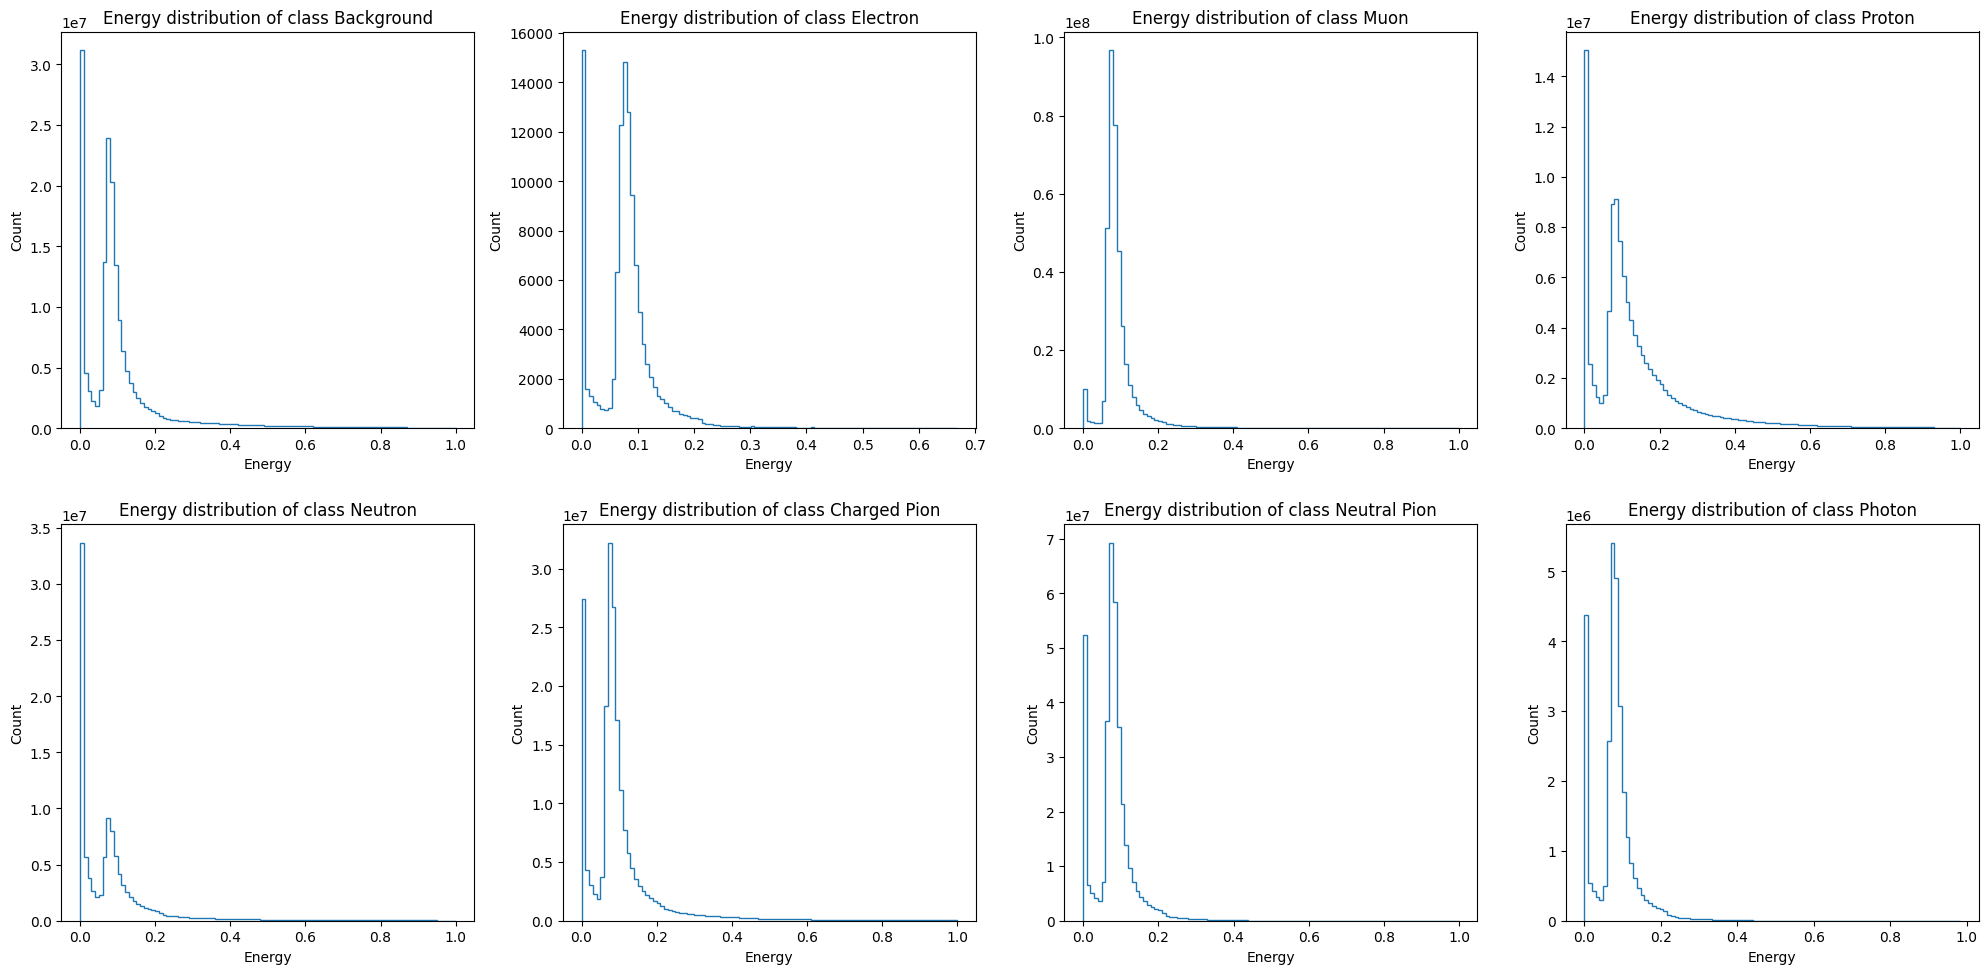

In [20]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20,10))
class_names = ["Background", "Electron", "Muon", "Proton", "Neutron", "Charged Pion", "Neutral Pion", "Photon"]
for c, ax in enumerate(axs.ravel()):
    mask = (numu_classes == c) & (numu_energies < 1) 
    ax.hist(numu_energies[mask], bins=100, histtype='step')
    ax.set_xlabel("Energy")
    ax.set_ylabel("Count")
    ax.set_title(f"Energy distribution of class {class_names[c]}")
plt.tight_layout()
plt.show()


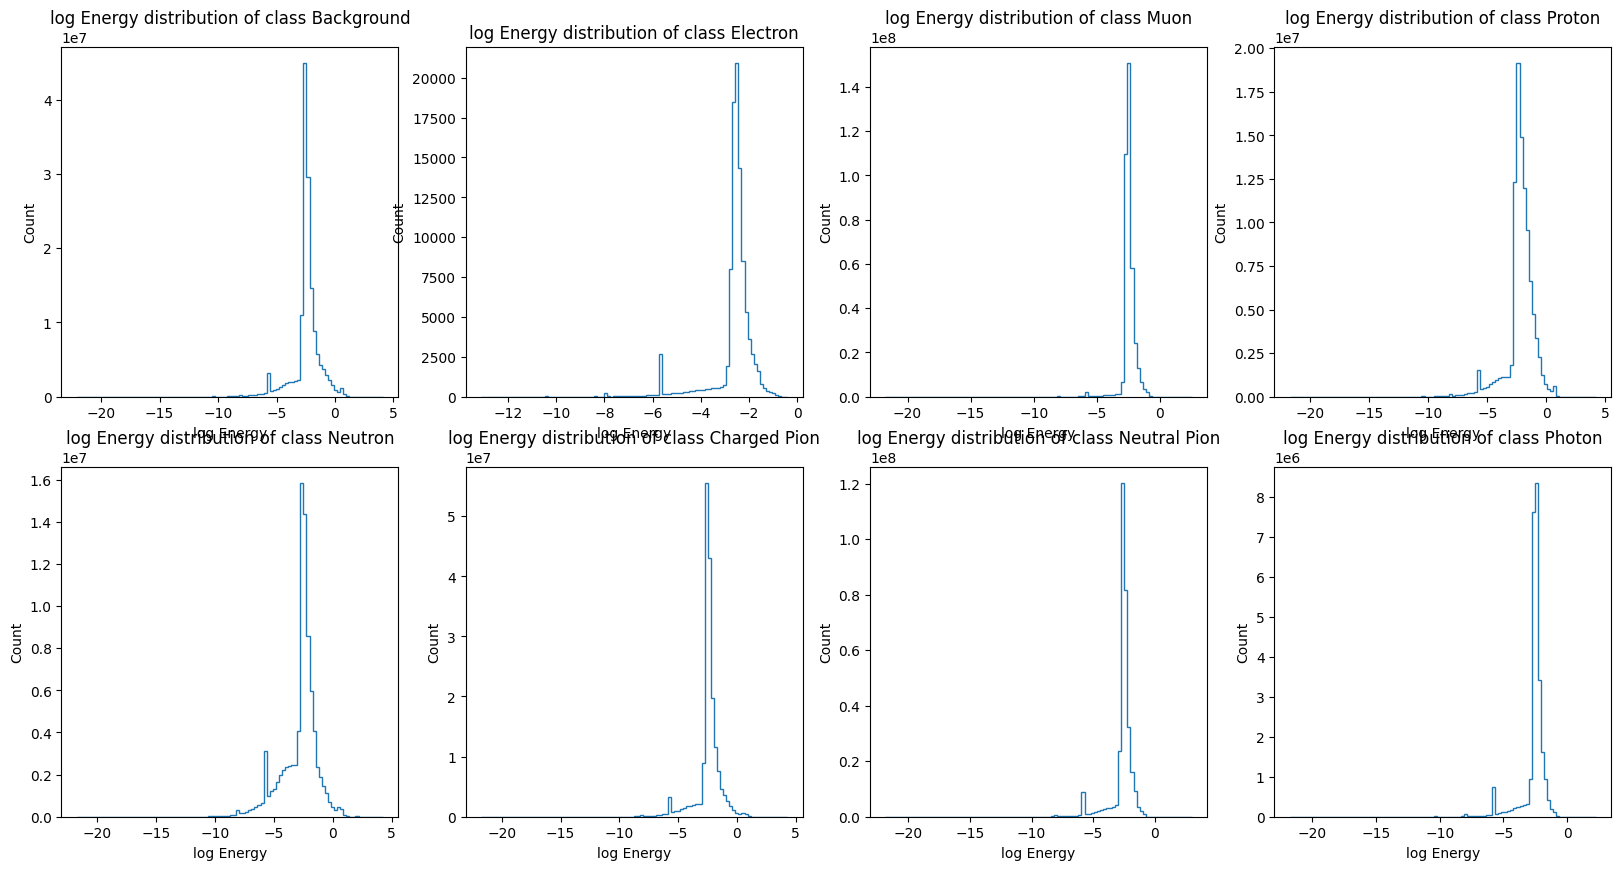

In [21]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20,10))
class_names = ["Background", "Electron", "Muon", "Proton", "Neutron", "Charged Pion", "Neutral Pion", "Photon"]
for c, ax in enumerate(axs.ravel()):
    mask = numu_classes == c
    log_energy = np.log(numu_energies[(numu_energies > 0) & mask])
    ax.hist(log_energy, bins=100, histtype='step')
    ax.set_xlabel("log Energy")
    ax.set_ylabel("Count")
    ax.set_title(f"log Energy distribution of class {class_names[c]}")
plt.show()

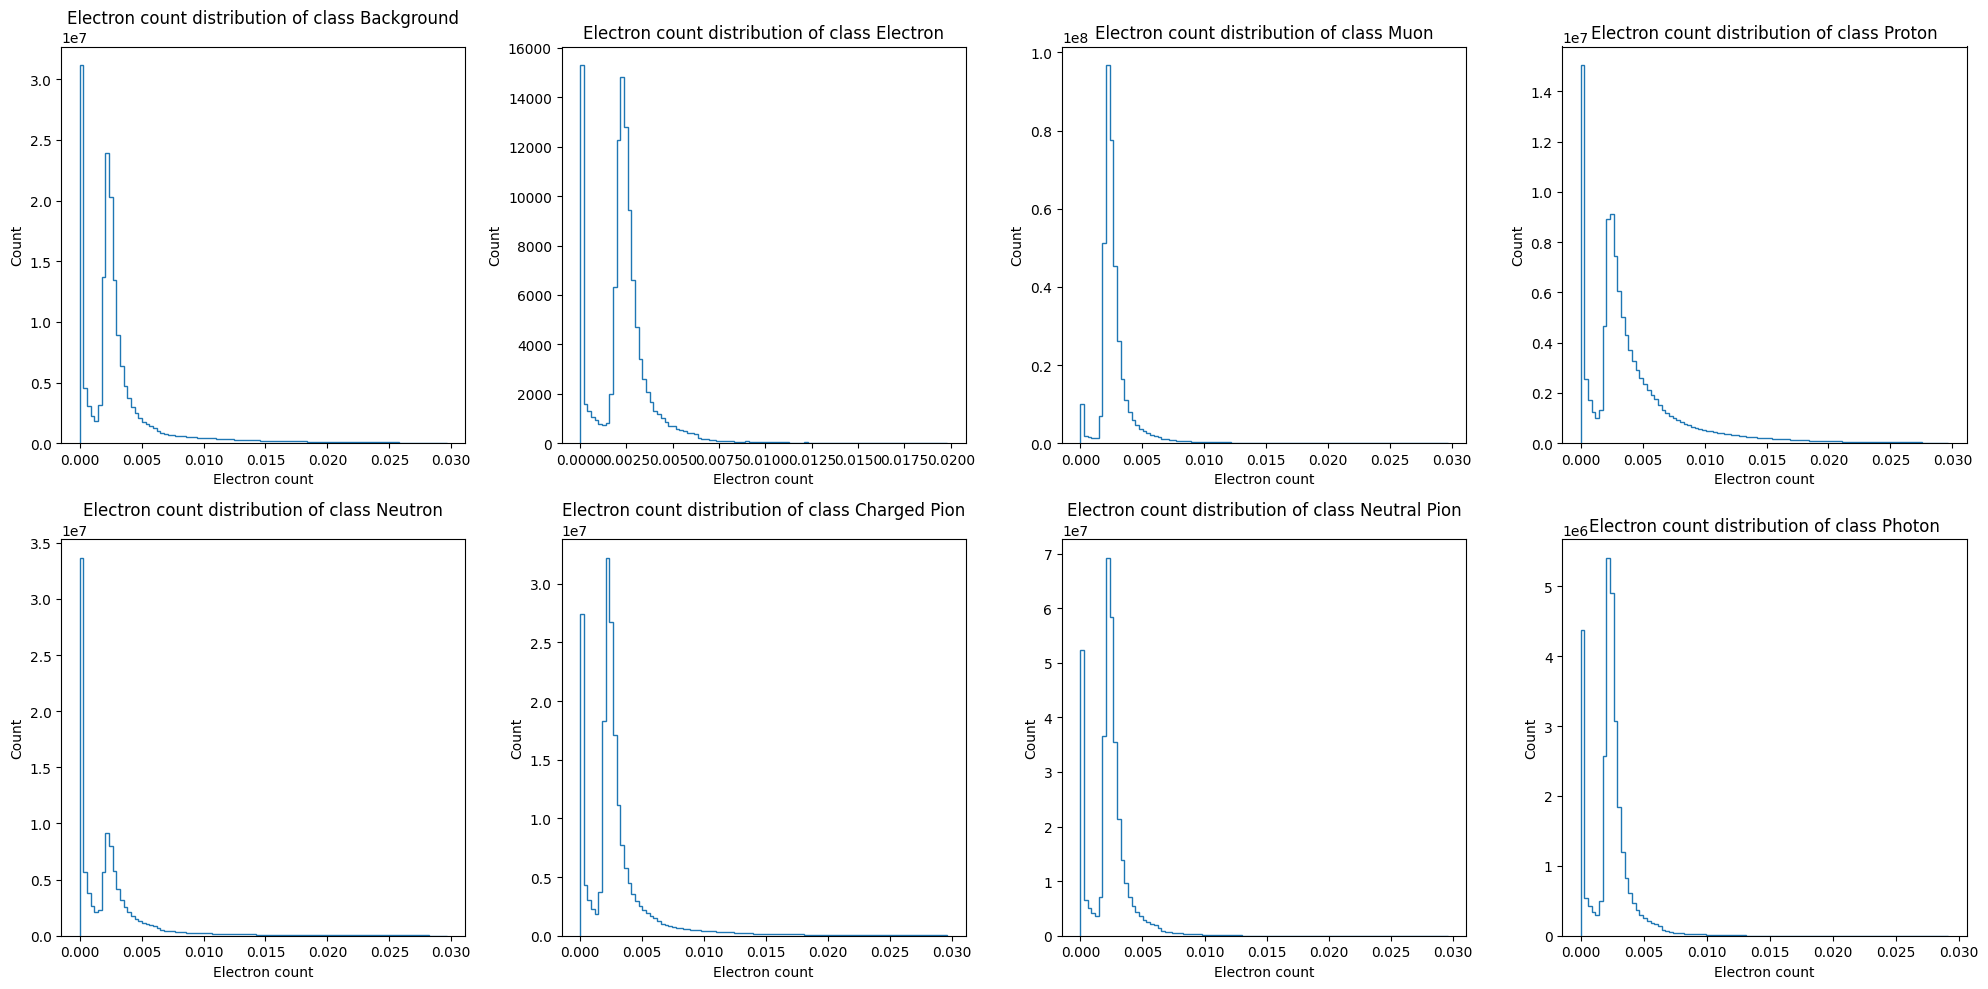

In [22]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20,10))
class_names = ["Background", "Electron", "Muon", "Proton", "Neutron", "Charged Pion", "Neutral Pion", "Photon"]
for c, ax in enumerate(axs.ravel()):
    mask = (numu_classes == c) & (numu_energies < 1)
    N_ei = (numu_energies/23.6)*0.7
    ax.hist(N_ei[mask], bins=100, histtype='step')
    ax.set_xlabel("Electron count")
    ax.set_ylabel("Count")
    ax.set_title(f"Electron count distribution of class {class_names[c]}")
plt.tight_layout()
plt.show()


In [23]:
import pandas as pd

In [25]:
numu_coords.shape
numu_energies
numu_primary
numu_classes
numu_primary_classes
numu_coords
numu_energies.shape

(1381522093,)

In [34]:
df = pd.DataFrame({
    "x": numu_coords[:,0],
    "y": numu_coords[:,1],
    "z": numu_coords[:,2],
    "evtid": numu_evtids,
    "energy": numu_energies,
    "class": numu_classes,
    "primary_class": numu_primary_classes
})

In [35]:
df.head()

,x,y,z,evtid,energy,class,primary_class
0,-584.213013,-574.380127,6883.501953,0,0.100219,0,0
1,-584.215820,-573.972107,6883.213379,0,0.081632,0,0
2,-584.220337,-573.564331,6882.923828,0,0.124583,0,0
3,-584.225037,-573.156799,6882.634277,0,0.092421,0,0
4,-584.230347,-572.748657,6882.345703,0,0.096406,0,0


In [36]:
df["x"] = df["x"] // 5
df["y"] = df["y"] // 5
df["z"] = df["z"] // 5

In [37]:
dfgb = df.groupby(by=["evtid","x","y","z"]).agg({
        "class": lambda x: pd.Series.mode(x)[0],
        "primary_class": lambda x: pd.Series.mode(x)[0],
        "energy": "sum"
    }).reset_index()


KeyboardInterrupt



In [38]:
dfgb.head()

NameError: name 'dfgb' is not defined

In [ ]:
1

In [ ]:
1